## 0.0. IMPORTS

In [2]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import xgboost as xgb
import umap.umap_ as umap
import pickle
import json
import requests

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from itertools import chain

### 0.1. Helper Functions

In [3]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])

def cross_validation(X, kfold, model_name, model, verbose=False, count_index=0):
    mae_list = []
    mape_list = []
    rmse_list = []
    kf = KFold(n_splits=kfold)

    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        train_data, test_data = X.iloc[train_index,:], X.iloc[test_index,:]

        y_test = test_data.pop('faturamento')
        y_train = train_data.pop('faturamento')
        
        # model
        m = model.fit(train_data, y_train)

        # prediction
        yhat = m.predict(test_data)

        # performance
        m_result = ml_error (model_name, np.expm1(y_test), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=([count_index-1]))

def cv_classification(X_2, kfold, model_name, model, verbose = False, count_index = 0):
    kf = KFold(n_splits=5)
    accuracy_list = []

    for train_index, test_index in kf.split(X_2):
        #print("TRAIN:", train_index, "TEST:", test_index)

        train_data, test_data = X_2.iloc[train_index,:], X_2.iloc[test_index,:]

        y_test = test_data.pop('potencial')
        y_train = train_data.pop('potencial')

        # model
        m = model.fit(train_data, y_train)

        # prediction
        yhat = m.predict(test_data)

        # performance
        m_result = model.score(test_data, y_test) * 100

        # store performance of each kfold iteration
        accuracy_list.append(m_result)

    return pd.DataFrame({'Model Name': model_name,
                         'Accuracy CV': np.round(np.mean(accuracy_list), 2).astype(str) + ' +/- ' + np.round(np.std(accuracy_list), 2).astype(str)}, index=([count_index-1]))

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [5]:
df_raw = pd.read_csv('datasets/DadosDesafioCientista.csv', encoding = 'ISO-8859-1')

In [6]:
df_raw.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515.00,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833.00,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200.00,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727,912226.00,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020.00,Médio


### 0.3. Split Dataset

In [7]:
# rj
df_rj = df_raw[df_raw['estado'] == 'RJ']

# sp
df_sp = df_raw[df_raw['estado'] == 'SP']

## 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [8]:
df1 = df_rj.copy()

### 1.1. Data Info

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo        160 non-null    int64  
 1   nome          160 non-null    object 
 2   cidade        160 non-null    object 
 3   estado        160 non-null    object 
 4   população     160 non-null    int64  
 5   popAte9       160 non-null    int64  
 6   popDe10a14    160 non-null    int64  
 7   popDe15a19    160 non-null    int64  
 8   popDe20a24    160 non-null    int64  
 9   popDe25a34    160 non-null    int64  
 10  popDe35a49    160 non-null    int64  
 11  popDe50a59    160 non-null    int64  
 12  popMaisDe60   160 non-null    int64  
 13  domiciliosA1  160 non-null    int64  
 14  domiciliosA2  160 non-null    int64  
 15  domiciliosB1  160 non-null    int64  
 16  domiciliosB2  160 non-null    int64  
 17  domiciliosC1  160 non-null    int64  
 18  domiciliosC2  160 non-null    

### 1.2. Corrigir DataTypes

In [10]:
df1['rendaMedia'] = df1['rendaMedia'].astype(float64)

### 1.3. Check NA

In [11]:
df1.isna().sum()

codigo          0
nome            0
cidade          0
estado          0
população       0
popAte9         0
popDe10a14      0
popDe15a19      0
popDe20a24      0
popDe25a34      0
popDe35a49      0
popDe50a59      0
popMaisDe60     0
domiciliosA1    0
domiciliosA2    0
domiciliosB1    0
domiciliosB2    0
domiciliosC1    0
domiciliosC2    0
domiciliosD     0
domiciliosE     0
rendaMedia      6
faturamento     0
potencial       0
dtype: int64

### 1.4. Fillout NA

In [12]:
imputer = KNNImputer(n_neighbors=5)
df_aux = df1.copy()
df_aux = df_aux.drop(['nome', 'cidade', 'estado', 'população', 'popAte9', 'popDe10a14', 'popDe15a19', 
                   'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60', 'faturamento', 'potencial'], axis = 1)
df_aux = pd.DataFrame(imputer.fit_transform(df_aux), columns = df_aux.columns)

In [13]:
df1 = df1.drop('rendaMedia', axis = 1)

In [14]:
df1 = pd.merge(df1, df_aux[['rendaMedia', 'codigo']], how='left', on='codigo')
df1 = df1[df1['população'] > 0]

**1.** Foi utilizado o KNNImputer para completar os NAs do dataset. Além disso, linhas com população igual a zero foram filtradas.

### 1.5. Estatística Descritiva

In [15]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64']).drop(['codigo', 'população'], axis = 1)

#### 1.5.1. Atributos Numéricos

In [16]:
describe(df1, ['skew', 'kurt'])

,codigo,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,faturamento,rendaMedia
count,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00,160.00
mean,3304557080.50,42654.35,5329.06,2484.44,3272.16,3349.38,6584.48,8826.86,5332.26,7475.71,388.48,608.27,1871.56,2385.07,3539.85,3030.81,568.38,1821.61,876159.97,3585.98
std,46.33,64262.95,10816.20,4948.83,5752.16,5601.89,9049.90,11536.28,7986.26,10258.31,1403.61,1535.24,2973.53,2779.07,4324.54,4003.05,823.92,2292.08,438210.60,5984.28
min,3304557001.00,173.00,33.00,13.00,22.00,17.00,28.00,38.00,10.00,12.00,0.00,0.00,0.00,0.00,5.00,3.00,0.00,2.00,24651.00,654.00
25%,3304557040.75,13362.75,1512.75,690.75,945.00,994.75,2131.25,2900.75,1598.75,2118.25,0.00,0.00,391.50,716.00,1088.75,789.75,117.75,431.50,711278.50,1498.00
50%,3304557080.50,26076.00,3111.50,1434.00,2015.00,2142.50,4170.50,5657.00,3371.50,4575.50,0.00,107.50,848.00,1536.00,2394.50,1861.50,327.50,1042.50,824228.50,1938.50
75%,3304557120.25,46504.50,5622.25,2621.50,3448.75,3451.75,7145.25,9586.75,6333.25,9196.00,1.00,430.50,1962.50,3065.75,4203.00,3652.50,694.00,2138.25,934320.75,2968.75
max,3304557160.00,667603.00,122578.00,55935.00,62342.00,60567.00,86116.00,105316.00,83341.00,91408.00,13408.00,11668.00,19350.00,21237.00,33111.00,25779.00,4956.00,14833.00,2915612.00,63887.00
skew,0.00,6.43,8.46,8.39,7.40,7.25,5.16,4.69,6.50,4.73,6.22,4.74,3.70,3.36,3.60,3.32,3.27,2.94,1.36,7.06
kurt,-1.20,56.99,88.00,86.77,71.04,69.29,38.47,32.10,57.99,30.97,49.00,26.23,16.43,15.88,17.62,13.22,12.36,10.98,4.27,65.57


## 2.0. PASSO 02 - ANÁLISE EXPLORATÓRIA DE DADOS

In [17]:
df2 = df1.copy()

### 2.1. Análise Univariada

#### 2.1.1. Variável Resposta

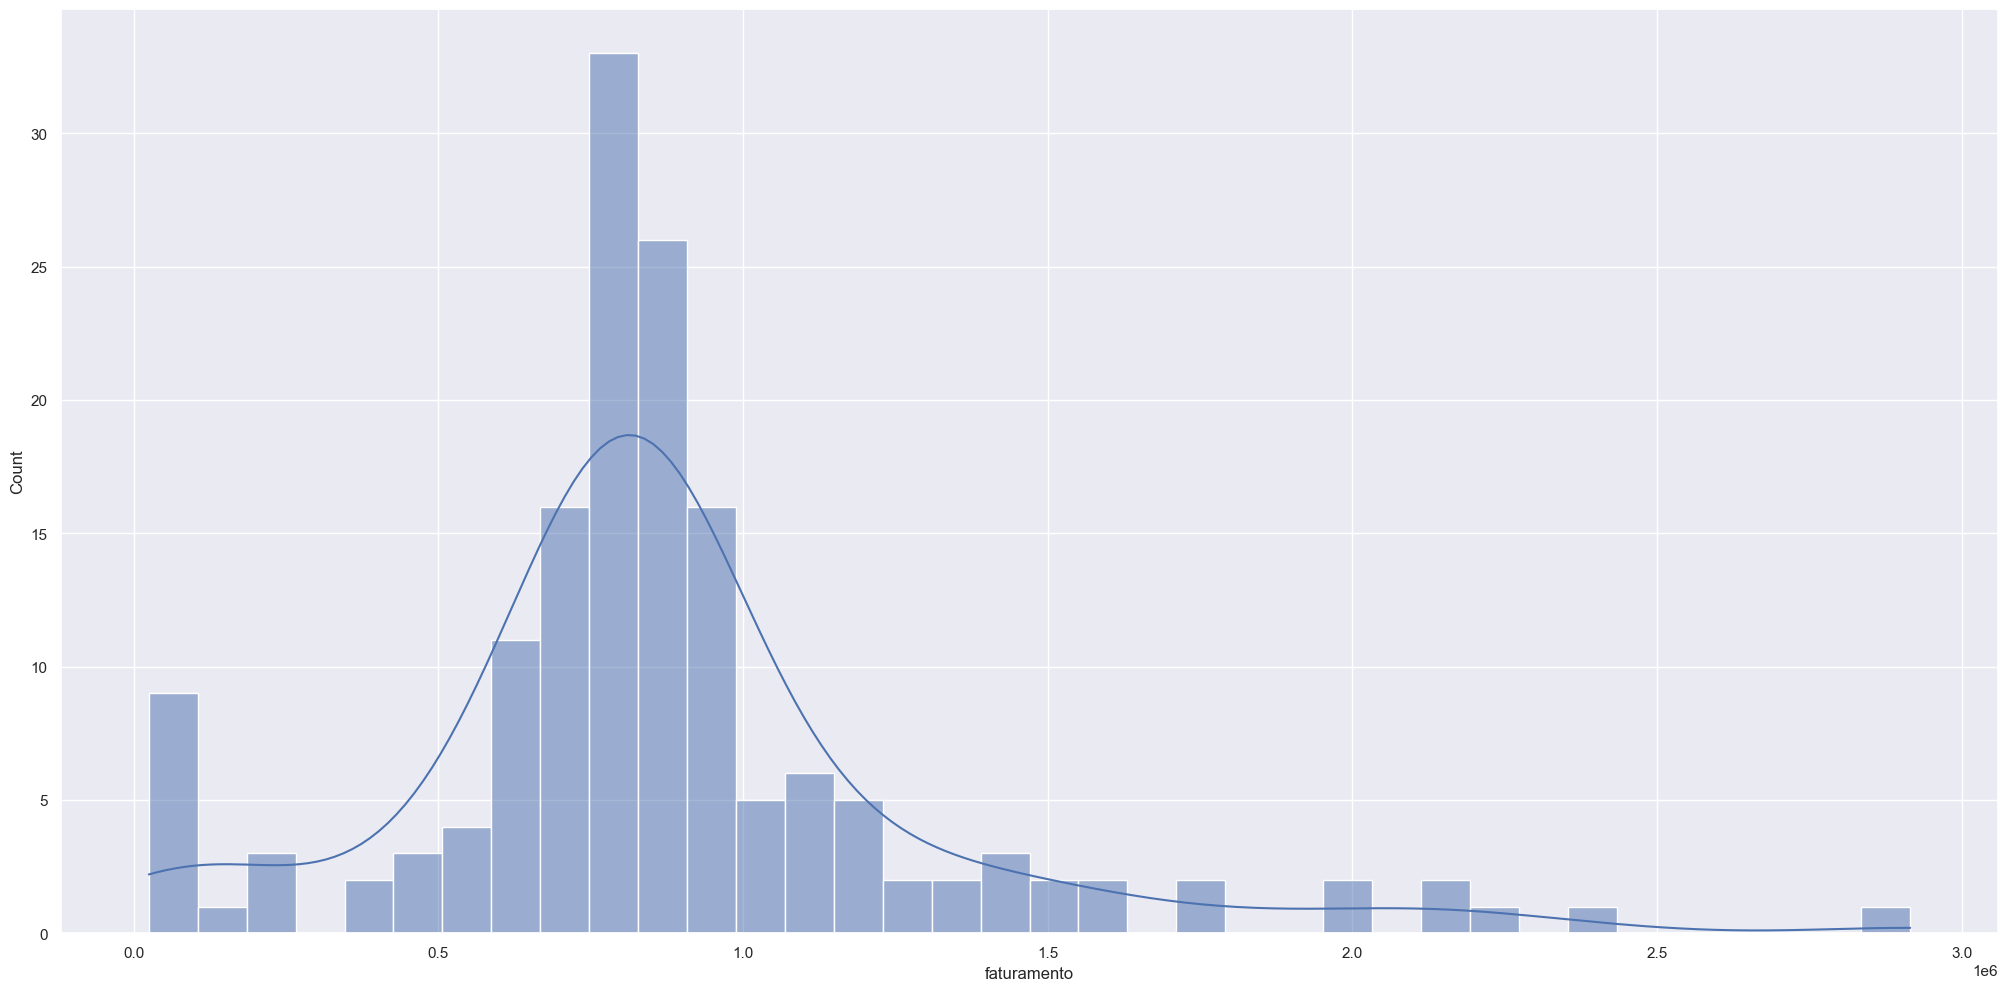

In [18]:
sns.histplot(df2['faturamento'], kde = True);

#### 2.1.2. Variáveis Numéricas

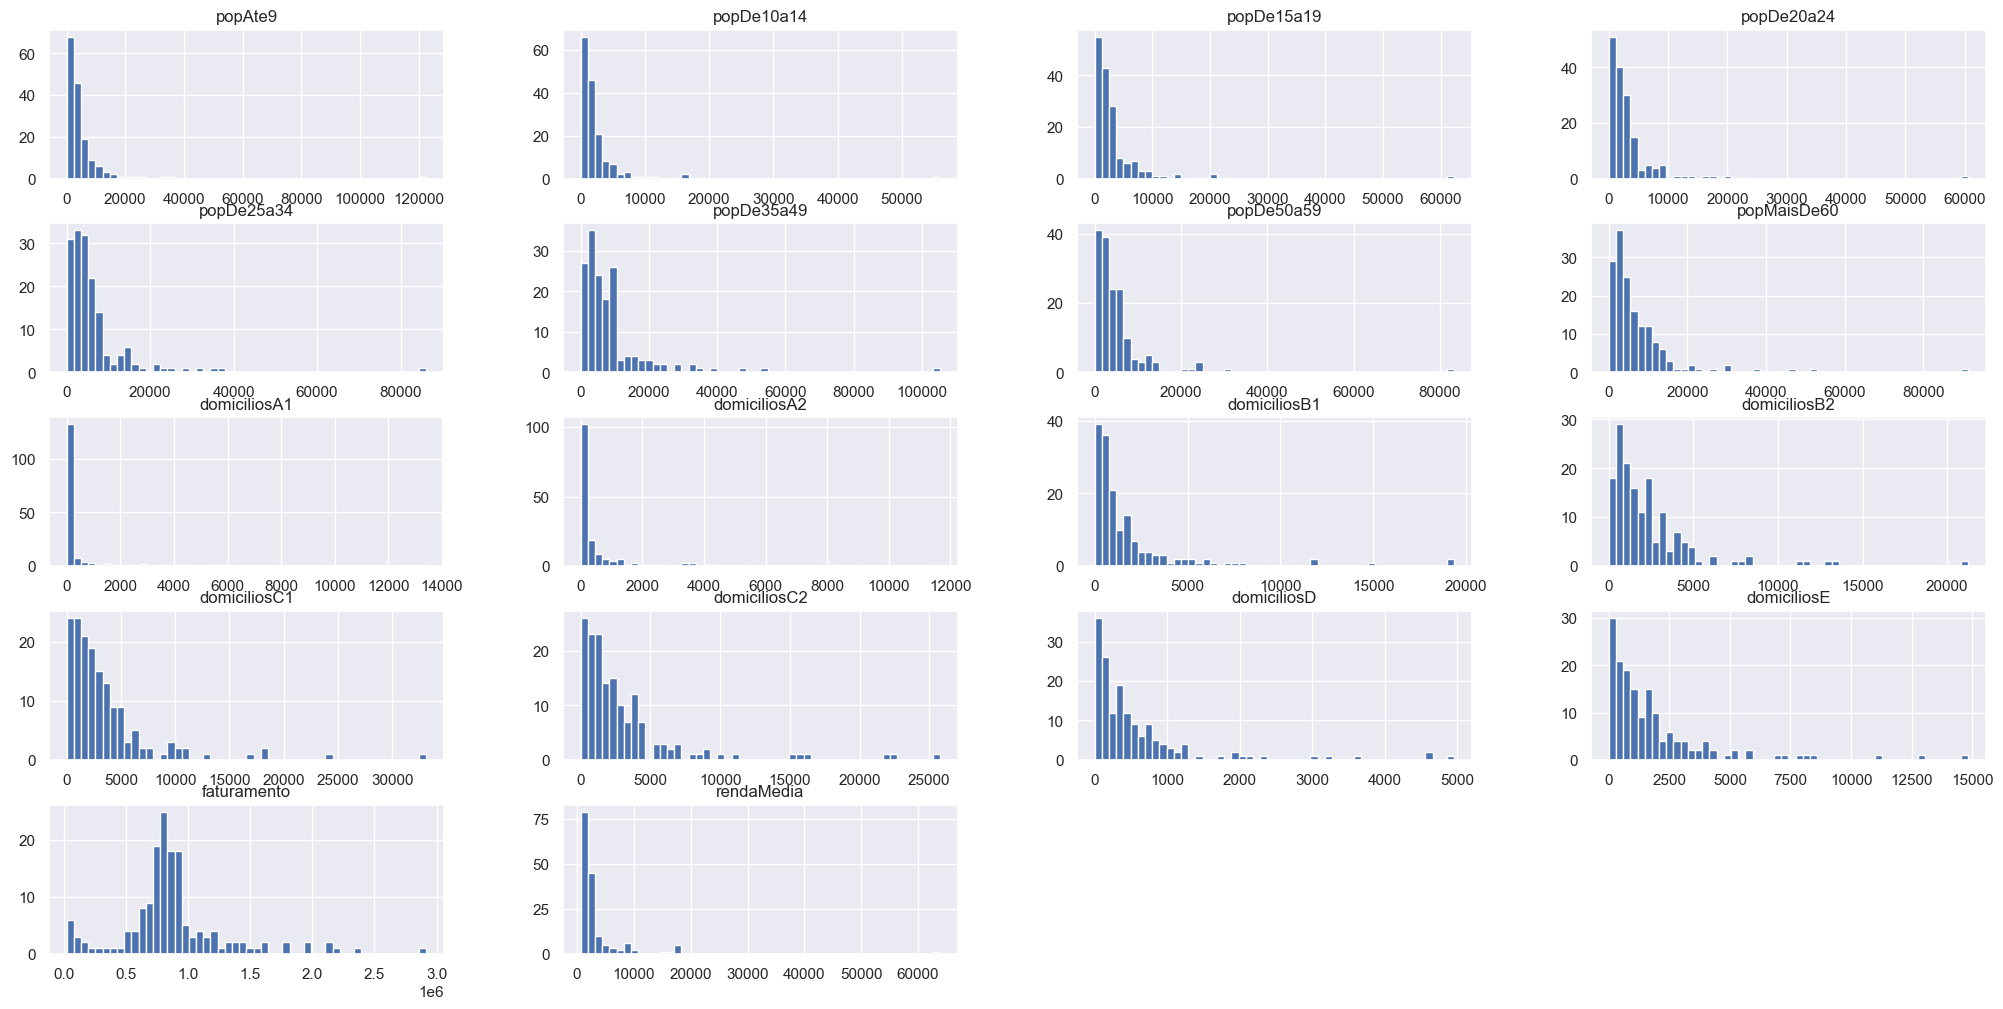

In [19]:
num_attributes.hist (bins = 50);

### 2.2. Análise Multivariada

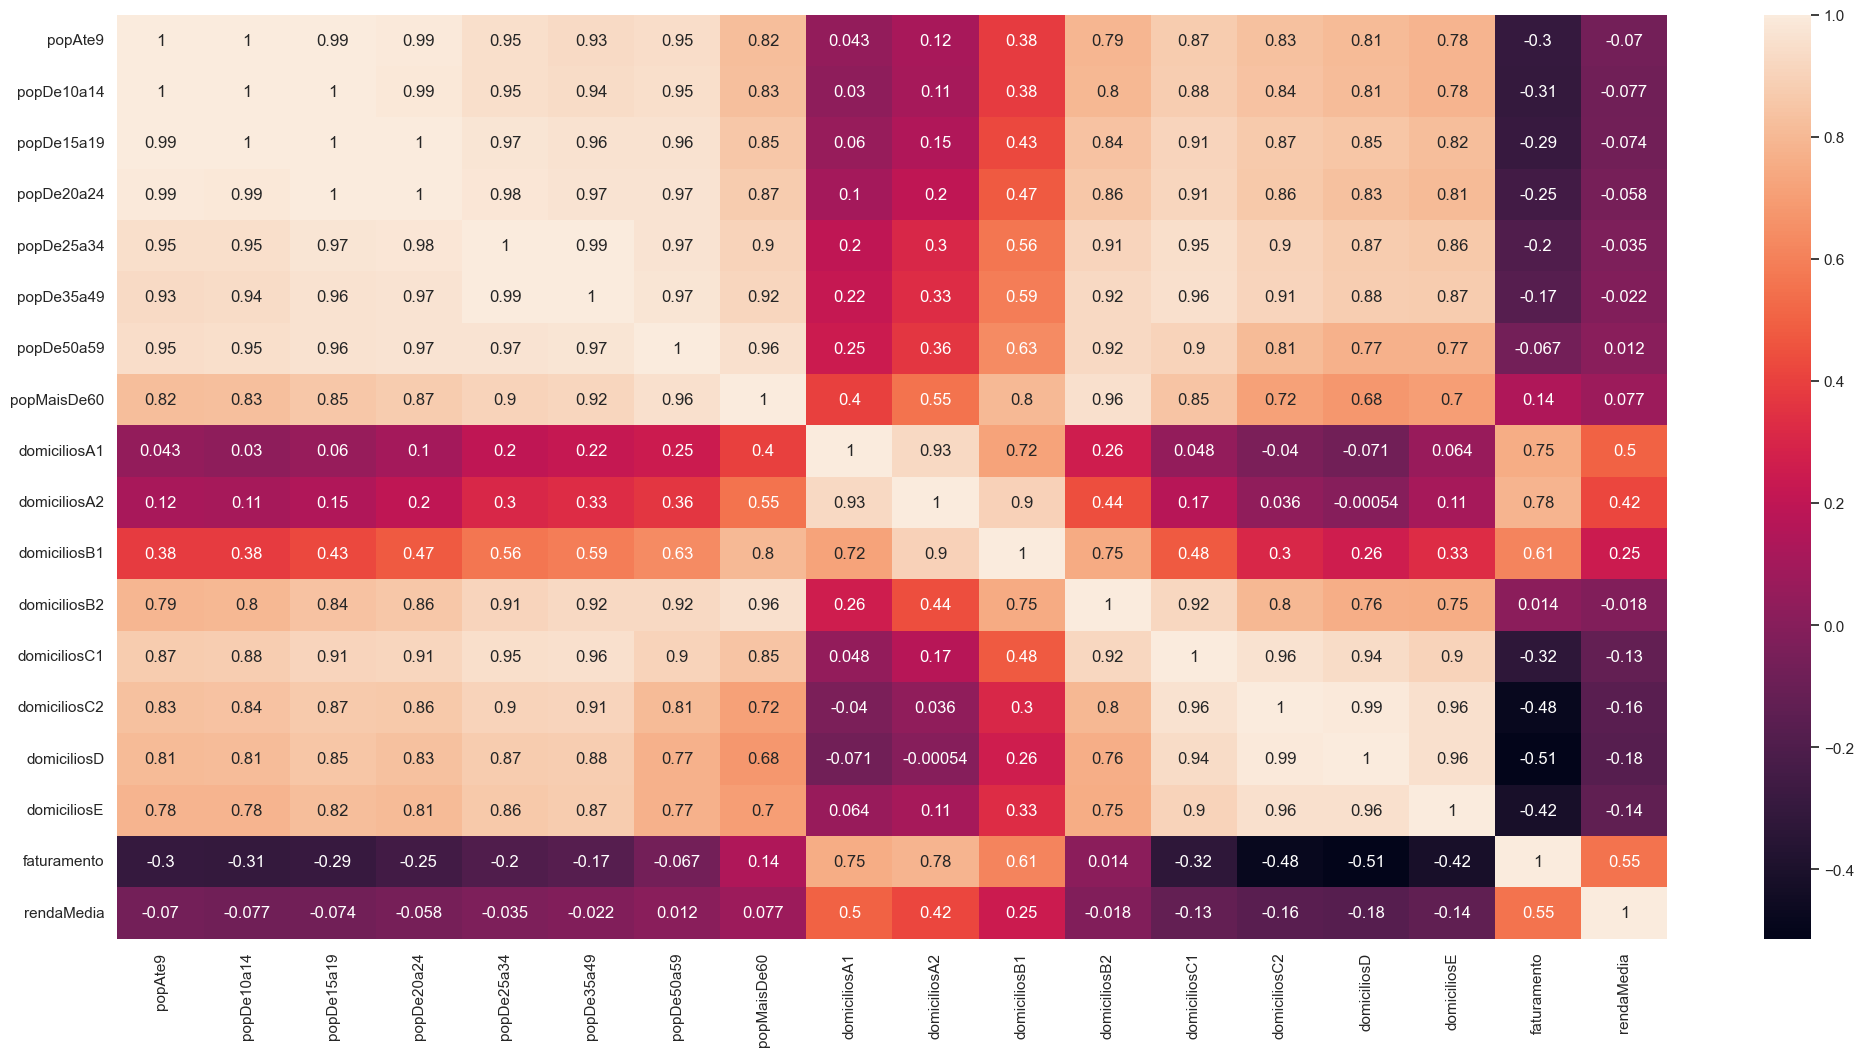

In [20]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

## 3.0. PASSO 03 - PREPARAÇÃO DOS DADOS

In [21]:
df3 = df2.copy()

### 3.1. Rescaling

In [22]:
rs = RobustScaler()
mms = MinMaxScaler()

In [23]:
# popAte9
df3['popAte9'] = rs.fit_transform (df3[['popAte9']].values)
pickle.dump(rs, open('parameter/popAte9_scaler.pkl', 'wb'))

# popDe10a14
df3['popDe10a14'] = rs.fit_transform (df3[['popDe10a14']].values)
pickle.dump(rs, open('parameter/popDe10a14_scaler.pkl', 'wb'))

# popDe15a19
df3['popDe15a19'] = rs.fit_transform (df3[['popDe15a19']].values)
pickle.dump(rs, open('parameter/popDe15a19_scaler.pkl', 'wb'))

# popDe20a24
df3['popDe20a24'] = rs.fit_transform (df3[['popDe20a24']].values)
pickle.dump(rs, open('parameter/popDe20a24_scaler.pkl', 'wb'))

# popDe25a34
df3['popDe25a34'] = rs.fit_transform (df3[['popDe25a34']].values)
pickle.dump(rs, open('parameter/popDe25a34_scaler.pkl', 'wb'))

# popDe35a49
df3['popDe35a49'] = rs.fit_transform (df3[['popDe35a49']].values)
pickle.dump(rs, open('parameter/popDe35a49_scaler.pkl', 'wb'))

# popDe50a59
df3['popDe50a59'] = rs.fit_transform (df3[['popDe50a59']].values)
pickle.dump(rs, open('parameter/popDe50a59_scaler.pkl', 'wb'))

# popMaisDe60
df3['popMaisDe60'] = rs.fit_transform (df3[['popMaisDe60']].values)
pickle.dump(rs, open('parameter/popMaisDe60_scaler.pkl', 'wb'))

# domiciliosA1
df3['domiciliosA1'] = mms.fit_transform (df3[['domiciliosA1']].values)
pickle.dump(mms, open('parameter/domiciliosA1_scaler.pkl', 'wb'))

# domiciliosA2
df3['domiciliosA2'] = rs.fit_transform (df3[['domiciliosA2']].values)
pickle.dump(rs, open('parameter/domiciliosA2_scaler.pkl', 'wb'))

# domiciliosB1
df3['domiciliosB1'] = rs.fit_transform (df3[['domiciliosB1']].values)
pickle.dump(rs, open('parameter/domiciliosB1_scaler.pkl', 'wb'))

# domiciliosB2
df3['domiciliosB2'] = rs.fit_transform (df3[['domiciliosB2']].values)
pickle.dump(rs, open('parameter/domiciliosB2_scaler.pkl', 'wb'))

# domiciliosC1
df3['domiciliosC1'] = rs.fit_transform (df3[['domiciliosC1']].values)
pickle.dump(rs, open('parameter/domiciliosC1_scaler.pkl', 'wb'))

# domiciliosC2
df3['domiciliosC2'] = rs.fit_transform (df3[['domiciliosC2']].values)
pickle.dump(rs, open('parameter/domiciliosC2_scaler.pkl', 'wb'))

# domiciliosD
df3['domiciliosD'] = rs.fit_transform (df3[['domiciliosD']].values)
pickle.dump(rs, open('parameter/domiciliosD_scaler.pkl', 'wb'))

# domiciliosE
df3['domiciliosE'] = rs.fit_transform (df3[['domiciliosE']].values)
pickle.dump(rs, open('parameter/domiciliosE_scaler.pkl', 'wb'))

# rendaMedia
df3['rendaMedia'] = rs.fit_transform (df3[['rendaMedia']].values)
pickle.dump(rs, open('parameter/rendaMedia_scaler.pkl', 'wb'))

**1.** Foi utilizado o RobustScaler devido a presença de outliers em todas as features.

**2.** Para 'domiciliosA1' foi utilizado o MinMaxScaler, pois o valor Q3 dessa feature é 1, e o Q1 é 0. Como o denominador do RobustScaler é Q3 - Q1, o rescaling apresentava nenhuma mudança.

### 3.2. Encoding

In [24]:
# potencial - Ordinal Encoding
potencial_dict = {'Baixo': 0, 'Médio': 1, 'Alto': 2}
df3['potencial'] = df3['potencial'].map(potencial_dict)
df3['potencial'] = df3['potencial'].astype(float64)

### 3.3. Transformação da Variável Resposta

In [25]:
df3['faturamento'] = np.log1p (df3['faturamento'])

<AxesSubplot: xlabel='faturamento', ylabel='Count'>

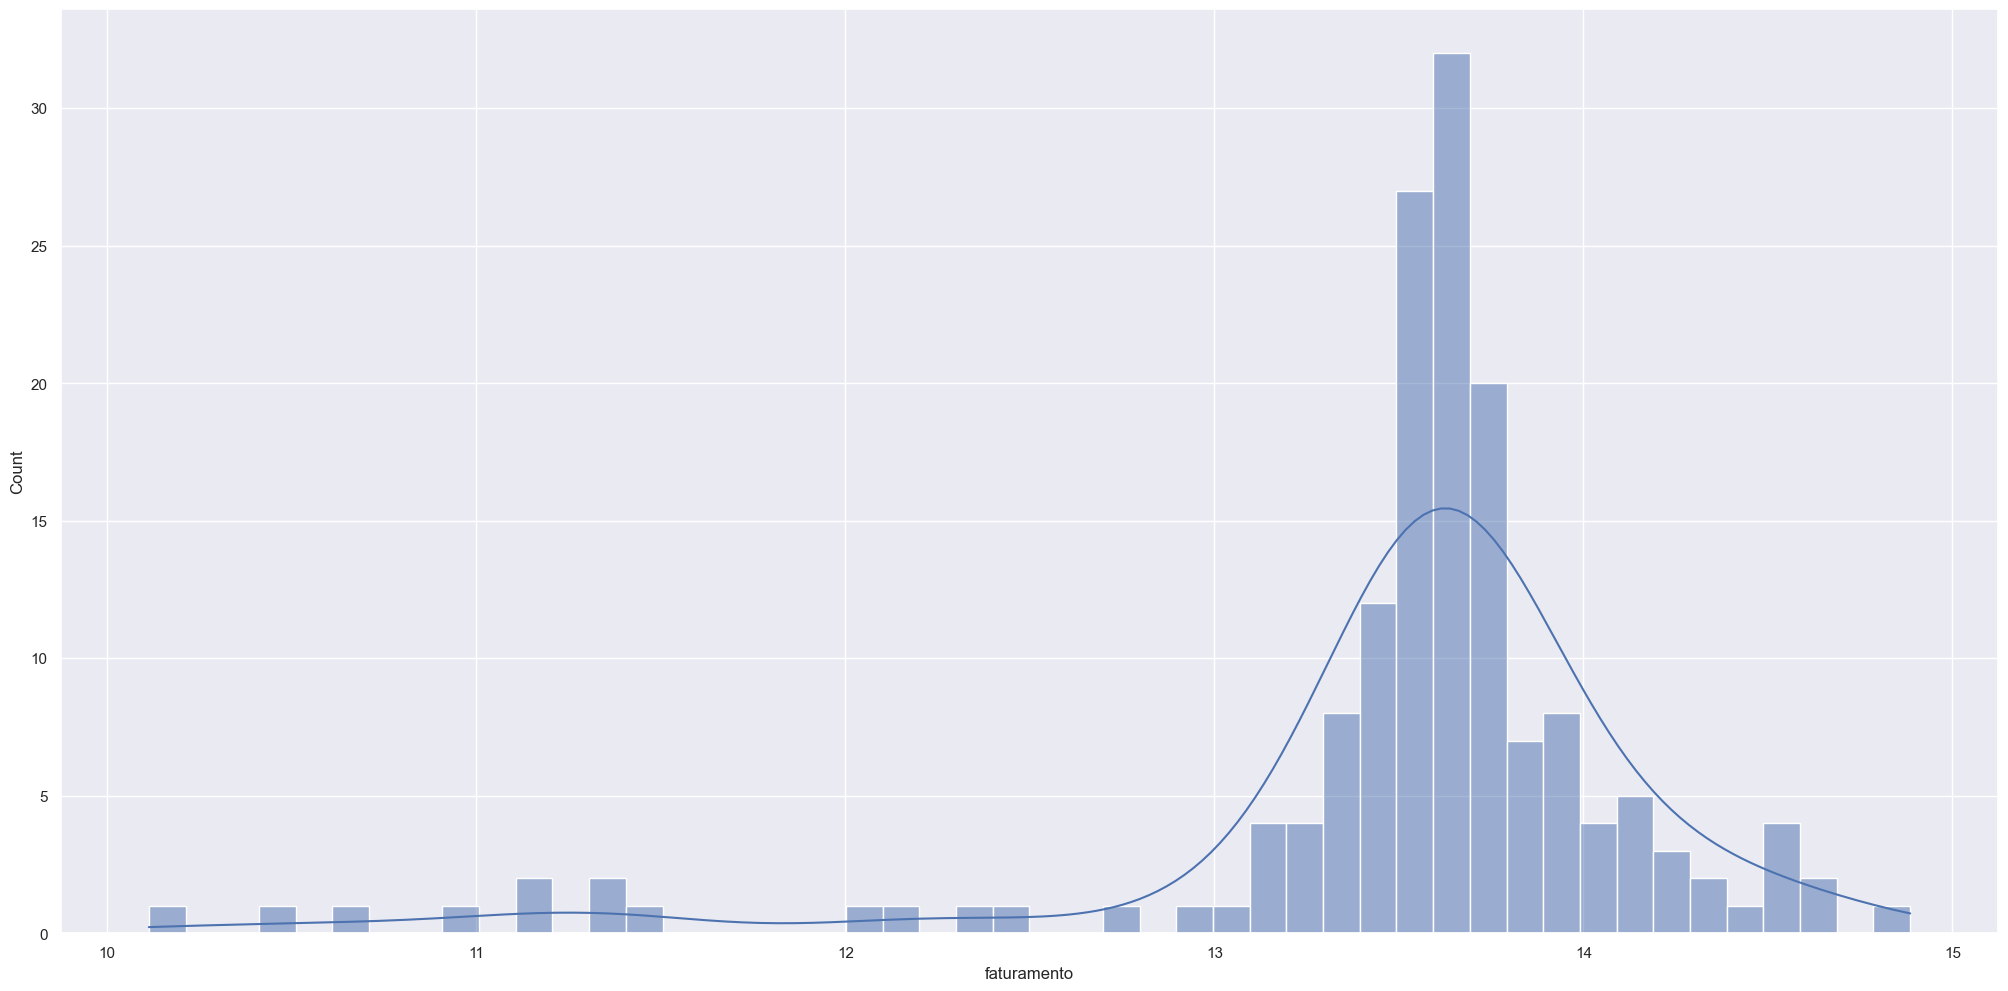

In [26]:
sns.histplot(df3['faturamento'], kde=True)

In [27]:
df_resc = df3.copy()

**1.** Transformação logarítica para a variável resposta melhorar sua distribuição normal.

## 4.0. Seleção de Features

In [28]:
df4 = df3.copy()

In [29]:
cols_drop = ['codigo', 'nome', 'cidade', 'estado', 'população']
df4 = df4.drop(cols_drop, axis = 1)
cols_selected_full = df4.columns

### 4.1. Dataset Split

In [30]:
k = 5
X_test = df4.iloc[(k-1)*32:k*32,:]
X_train = df4.drop(X_test.index)

y_test = X_test.pop('faturamento')
y_train = X_train.pop('faturamento')

**1.** Split inicial do dataset, na proporção 80:20 para treino:teste. A frente do código, foi utilizado o algoritmo de cross-validation para separar o dataset.

## 5.0. Modelo de Machine Learning

In [31]:
X_train = X_train.drop('potencial', axis = 1)
X_test = X_test.drop('potencial', axis = 1)

# Cross Validation - Faturamento
X = df4.drop('potencial', axis = 1)

# Cross Validation - Potencial
X_2 = df4.drop('faturamento', axis = 1)

### 5.1. Modelos de Predição

* Linear Regression
* Lasso
* Random Forest Regressor
* XGBoost Regressor

#### 5.1.1. Linear Regression Model

In [32]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1(y_test), np.expm1 (yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,104415.72,0.10,219109.83


##### 5.1.1.1. Linear Regression Model - Cross Validation

In [33]:
X = df4.drop('potencial', axis = 1)

In [34]:
lr_result_cv = cross_validation(X, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,Linear Regression,2042391427.05 +/- 4084509593.85,29322.05 +/- 58643.76,11552208850.68 +/- 23103829894.18


#### 5.1.2. Linear Regression Regularized Model - Lasso

In [35]:
# model
lrr = Lasso(alpha = 0.01).fit(X_train, y_train)

# prediction
yhat_lrr = lrr.predict(X_test)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(y_test), np.expm1 (yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,78892.05,0.08,141152.59


##### 5.1.2.1. Linear Regression Regularized Model - Lasso - Cross Validation

In [36]:
lrr_result_cv = cross_validation(X, 5, 'Linear Regression - Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,Linear Regression - Lasso,154200.01 +/- 72037.36,0.45 +/- 0.57,417868.76 +/- 288248.72


#### 5.1.3. Random Forest Regressor

In [37]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 10).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(y_test), np.expm1 (yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,76099.64,0.09,121211.18


##### 5.1.3.1. Random Forest Regressor - Cross Validation

In [38]:
rf_result_cv = cross_validation(X, 5, 'Random Forest', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,Random Forest,82359.89 +/- 21250.11,0.14 +/- 0.04,167223.38 +/- 58764.73


#### 5.1.4. XGBoost Regressor

In [39]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=1700,
                              eta=0.03,
                              max_depth=9,
                              subsample=0.5,
                              colsample_bytree=0.3,
                              min_child_weight=3).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,78143.50,0.09,161984.83


##### 5.1.4.1. XGBoost Regressor - Cross Validation

In [40]:
xgb_result_cv = cross_validation(X, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,XGBoost Regressor,66898.68 +/- 15593.44,0.11 +/- 0.01,134477.21 +/- 51754.76


#### 5.1.5. Comparação de Desempenho entre Modelos - Regressão

##### 5.1.5.1. Single Performance

In [41]:
modelling_result = pd.concat([lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,76099.64,0.09,121211.18
0,Linear Regression - Lasso,78892.05,0.08,141152.59
0,XGBoost Regressor,78143.50,0.09,161984.83
0,Linear Regression,104415.72,0.10,219109.83


##### 5.1.5.2. Real Performance - Cross Validation

In [42]:
modelling_result_cv = pd.concat([lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,XGBoost Regressor,66898.68 +/- 15593.44,0.11 +/- 0.01,134477.21 +/- 51754.76
-1,Random Forest,82359.89 +/- 21250.11,0.14 +/- 0.04,167223.38 +/- 58764.73
-1,Linear Regression - Lasso,154200.01 +/- 72037.36,0.45 +/- 0.57,417868.76 +/- 288248.72


**1.** Modelo escolhido foi o XGBoost Regressor, por apresentar um melhor desempenho.

### 5.2. Modelos de Classificação

* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes Classifier
* Random Forest

#### 5.2.1. k-Nearest Neighbors

In [43]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn_result_cv = cv_classification(X_2, 5, 'k-Nearest Neighbors', knn)   

knn_result_cv

,Model Name,Accuracy CV
-1,k-Nearest Neighbors,81.25 +/- 6.56


#### 5.2.2. Support Vector Machine

In [44]:
svc = SVC()

svc_result_cv = cv_classification(X_2, 5, 'Support Vector Machine', svc)   

svc_result_cv

,Model Name,Accuracy CV
-1,Support Vector Machine,70.0 +/- 9.4


### 5.2.3. Gaussian Naive Bayes

In [45]:
gnb = GaussianNB()

gnb_result_cv = cv_classification(X_2, 5, 'Gaussian Naive Bayes', gnb)   

gnb_result_cv

,Model Name,Accuracy CV
-1,Gaussian Naive Bayes,61.88 +/- 7.5


#### 5.2.4. Random Forest Classifier

In [46]:
rfc = RandomForestClassifier()

rfc_result_cv = cv_classification(X_2, 5, 'Random Forest Classifier', rfc)   

rfc_result_cv

,Model Name,Accuracy CV
-1,Random Forest Classifier,88.75 +/- 3.19


#### 5.2.5. Comparação de Desempenho entre Modelos - Regressão

In [47]:
modelling_result_c_cv = pd.concat([knn_result_cv, svc_result_cv, gnb_result_cv, rfc_result_cv])
modelling_result_c_cv.sort_values('Accuracy CV', ascending = False)

,Model Name,Accuracy CV
-1,Random Forest Classifier,88.75 +/- 3.19
-1,k-Nearest Neighbors,81.25 +/- 6.56
-1,Support Vector Machine,70.0 +/- 9.4
-1,Gaussian Naive Bayes,61.88 +/- 7.5


**1.** O modelo escolhido foi o Random Forest Classifier, por apresentar um melhor desempenho.

## 6.0. PASSO 06 - HYPERPARAMETER FINE TUNING

### 6.1. Random Search - Regressão

In [48]:
#count = 1
#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]}
#    
#MAX_EVAL = 30

In [49]:
#final_result = pd.DataFrame()
#
#count = 1
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    hp.update ({'index': count})
#    print(hp)
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#    n_estimators=hp['n_estimators'],
#    eta=hp['eta'],
#    max_depth=hp['max_depth'],
#    subsample=hp['subsample'],
#    colsample_bytree=hp['colsample_bytree'],
#    min_child_weight=hp['min_child_weight'])
#    count += 1
#
#    # performance
#    result = cross_validation(X, 5, 'XGBoost Regressor', model_xgb, verbose=True, count_index = count)
#    final_result = pd.concat([final_result, result])
#
#final_result

### 6.2. Random Search - Classificação

In [50]:
#param = {
#            'bootstrap': [True],
#            'max_depth': [None, 80, 90, 100, 110],
#            'max_features': [2, 3, 5],
#            'min_samples_leaf': [1, 3, 4, 5],
#            'min_samples_split': [3, 8, 10, 12],
#            'n_estimators': [100, 500, 1000, 1500, 2500]}
#
#MAX_EVAL = 20

In [51]:
#final_result = pd.DataFrame()
#rfc_result = []
#count = 1
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    hp.update ({'index': count})
#    print(hp)
#    # model
#    rfc = RandomForestClassifier(bootstrap = True,
#            n_estimators=hp['n_estimators'],
#            max_depth=hp['max_depth'],
#            max_features = hp['max_features'],
#            min_samples_leaf = hp['min_samples_leaf'],
#            min_samples_split = hp['min_samples_split'])
#    count += 1
#    
#    # performance
#    rfc_result = cv_classification(X_2, 5, 'Random Forest Classifier', rfc, verbose = True, count_index = count)
#    final_result = pd.concat([final_result, rfc_result])
#    
#final_result

**1.** Os melhores resultados foram encontrados do hyperparameter fine tuning. O método utilizado foi o Random Search, onde combinações aleatórias de parâmetros são testados com o objetivo de encontrar o melhor resultado.

**2.** O código do Random Search foi deixado comentado para agilizar a produção do código ao compilar. O melhor resultado encontrado está descrito na célula abaixo.

## 7.0. PASSO 07 - MODELO FINAL

### 7.1. Regressão

In [52]:
# param tuned
param_tuned = {'n_estimators': 1700,
               'eta': 0.03,
               'max_depth': 5,
               'subsample': 0.7,
               'colsample_bytree': 0.3,
               'min_child_weight': 3}

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'])

In [53]:
xgb_result_tuned = cross_validation(X, 5, 'XGBoost Regressor', model_xgb_tuned)
xgb_result_tuned

,Model Name,MAE CV,MAPE CV,RMSE CV
-1,XGBoost Regressor,67263.66 +/- 17902.27,0.11 +/- 0.02,134688.72 +/- 43551.45


In [54]:
kf = KFold(n_splits=5)
yhat_xgb_tuned = []

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)

    train_data, test_data = X.iloc[train_index,:], X.iloc[test_index,:]

    y_test = test_data.pop('faturamento')
    y_train = train_data.pop('faturamento')
    
    m = model_xgb_tuned.fit(train_data, y_train)
    
    yhat_xgb_tuned.append(model_xgb_tuned.predict(test_data))

yhat_xgb_tuned = list(chain.from_iterable(yhat_xgb_tuned))

In [55]:
df2['predictions'] = np.expm1(yhat_xgb_tuned)

### 7.2. Classificação

In [56]:
param_tuned_c = {'bootstrap': True,
                 'max_depth': 90,
                 'max_features': 5,
                 'min_samples_leaf': 1,
                 'min_samples_split': 12,
                 'n_estimators': 2500}

model_rfc_tuned = RandomForestClassifier(bootstrap = True,
                                          max_depth =  90,
                                          max_features = 5,
                                          min_samples_leaf = 1,
                                          min_samples_split = 12,
                                          n_estimators = 2500)

In [57]:
rfc_result_tuned = cv_classification(X_2, 5, 'Random Forest Classifier', model_rfc_tuned)
rfc_result_tuned

,Model Name,Accuracy CV
-1,Random Forest Classifier,87.5 +/- 5.23


In [58]:
kf = KFold(n_splits=5)
yhat_rfc_tuned = []

for train_index, test_index in kf.split(X_2):
    #print("TRAIN:", train_index, "TEST:", test_index)

    train_data, test_data = X_2.iloc[train_index,:], X_2.iloc[test_index,:]

    y_test = test_data.pop('potencial')
    y_train = train_data.pop('potencial')
    
    m = model_rfc_tuned.fit(train_data, y_train)
    
    yhat_rfc_tuned.append(model_rfc_tuned.predict(test_data))

yhat_rfc_tuned = list(chain.from_iterable(yhat_rfc_tuned))

In [59]:
# potencial - Ordinal Encoding
df2['potencial'] = df2['potencial'].map(potencial_dict)
df2['potencial'] = df2['potencial'].astype(float64)

df2['potencial_classifier'] = yhat_rfc_tuned

## 8.0. PASSO 08 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [60]:
df8 = df2.copy()

### 8.1. Regressão

#### 8.1.1. Business Performance - Regressão

In [61]:
df8 = df2[['nome', 'faturamento', 'predictions']].groupby('nome').apply(lambda x: mean_absolute_error(x['faturamento'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df81_aux2 = df2[['nome', 'faturamento', 'predictions']].groupby('nome').apply(lambda x: mean_absolute_percentage_error(x['faturamento'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})
df81_aux3 = df2[['nome', 'faturamento', 'predictions']]

df8_aux = pd.merge(df8, df81_aux2, how='inner', on='nome')
df8_aux1 = pd.merge(df8_aux, df81_aux3, how='inner', on='nome')

df8_aux1['worst_scenario'] = df8_aux1['predictions'] - df8_aux1['MAE']
df8_aux1['best_scenario'] = df8_aux1['predictions'] + df8_aux1['MAE']

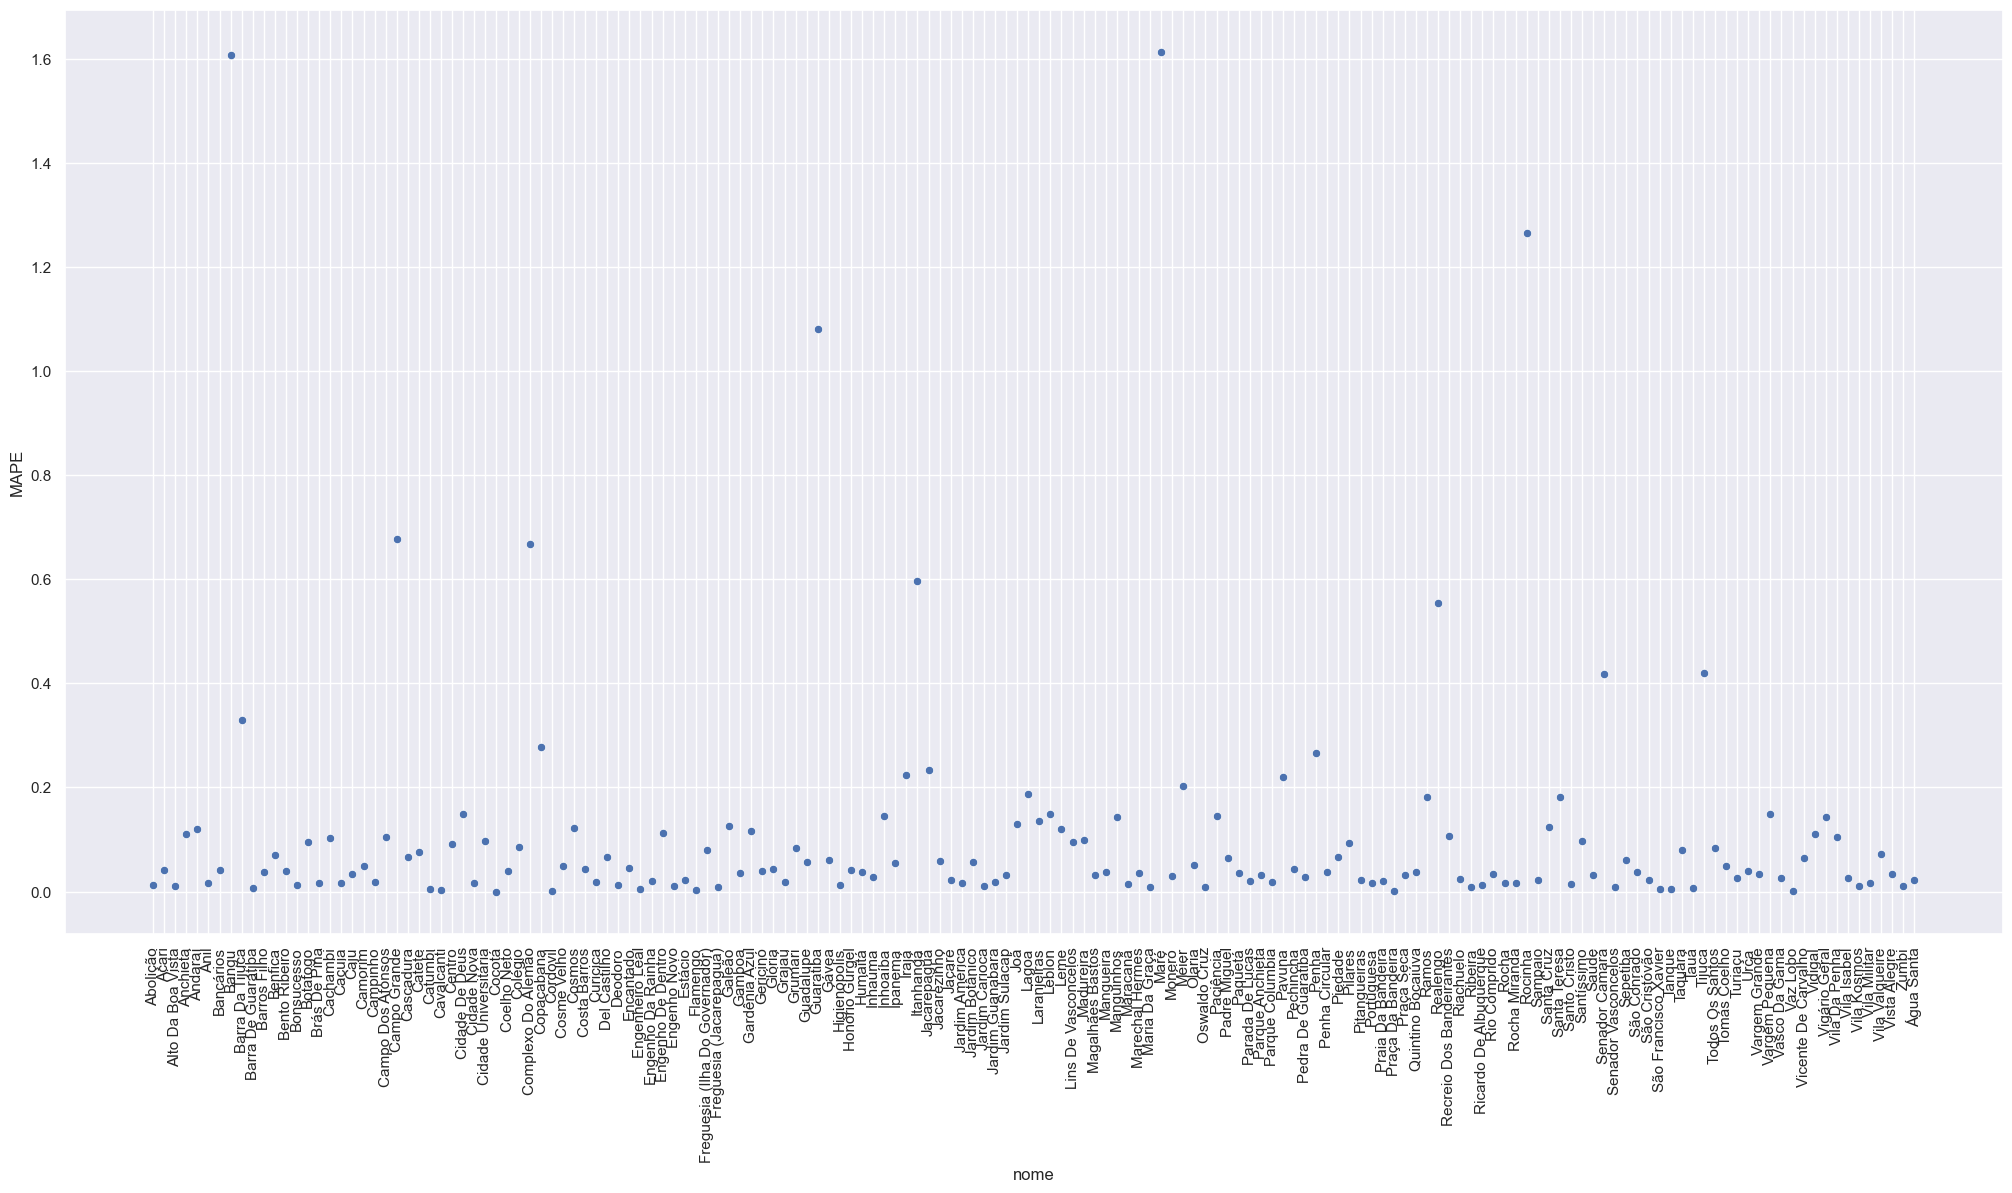

In [62]:
sns.scatterplot(x='nome', y='MAPE', data=df8_aux1);
plt.xticks (rotation = 90);

**1.** Pode-se observar que os MAPE dos bairros estão concentrados num valor
menor que 0.2. Isso significa que o modelo apresentou um acerto de predição de
faturamento de mais de 80 % na maioria dos bairros. Há de se observar, também, quatro
bairros com um resultado abaixo de 50 %.

#### 8.1.2. Machine Learning Performance

In [63]:
df8_aux1['error'] = df8_aux1['faturamento'] - df8_aux1['predictions']
df8_aux1['error_rate'] = df8_aux1['predictions'] / df8_aux1['faturamento']

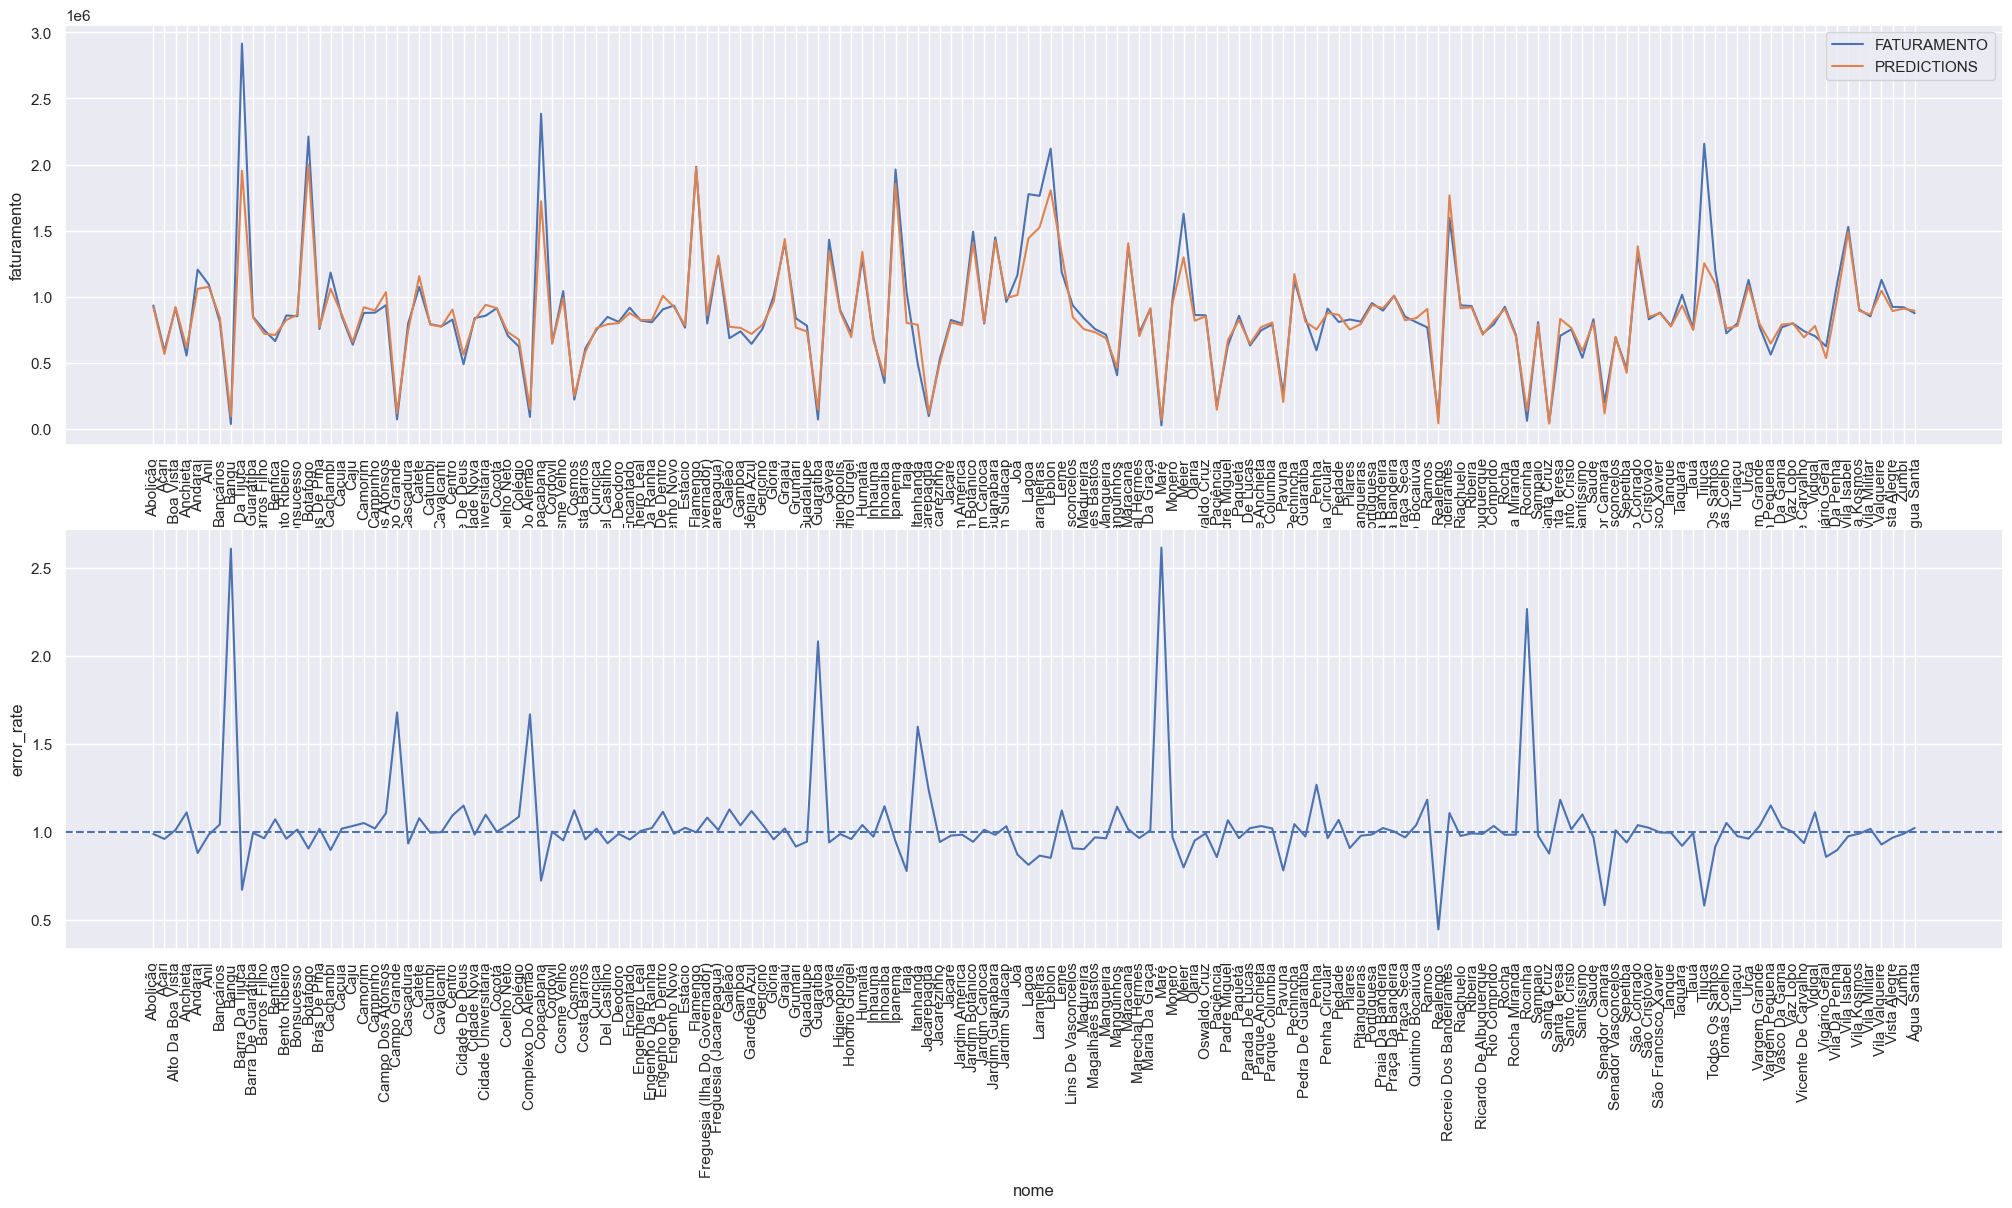

In [64]:
plt.subplot(2, 1, 1)
sns.lineplot(x='nome', y='faturamento', data = df8_aux1, label='FATURAMENTO');
sns.lineplot(x='nome', y='predictions', data = df8_aux1, label='PREDICTIONS');
plt.xticks (rotation = 90);

plt.subplot(2, 1, 2)
sns.lineplot(x='nome', y='error_rate', data = df8_aux1)
plt.axhline(1, linestyle='--');
plt.xticks (rotation = 90);

**1.** Pode-se observar que os valores das previsões e do faturamento seguem uma
relação próxima, mostrando a efetividade do modelo utilizado. No gráfico de baixo da
mesma figura, quando mais próximo de 1.0, melhor será o modelo. Novamente foi
observado quatro bairros que apresentaram resultados anômalos.

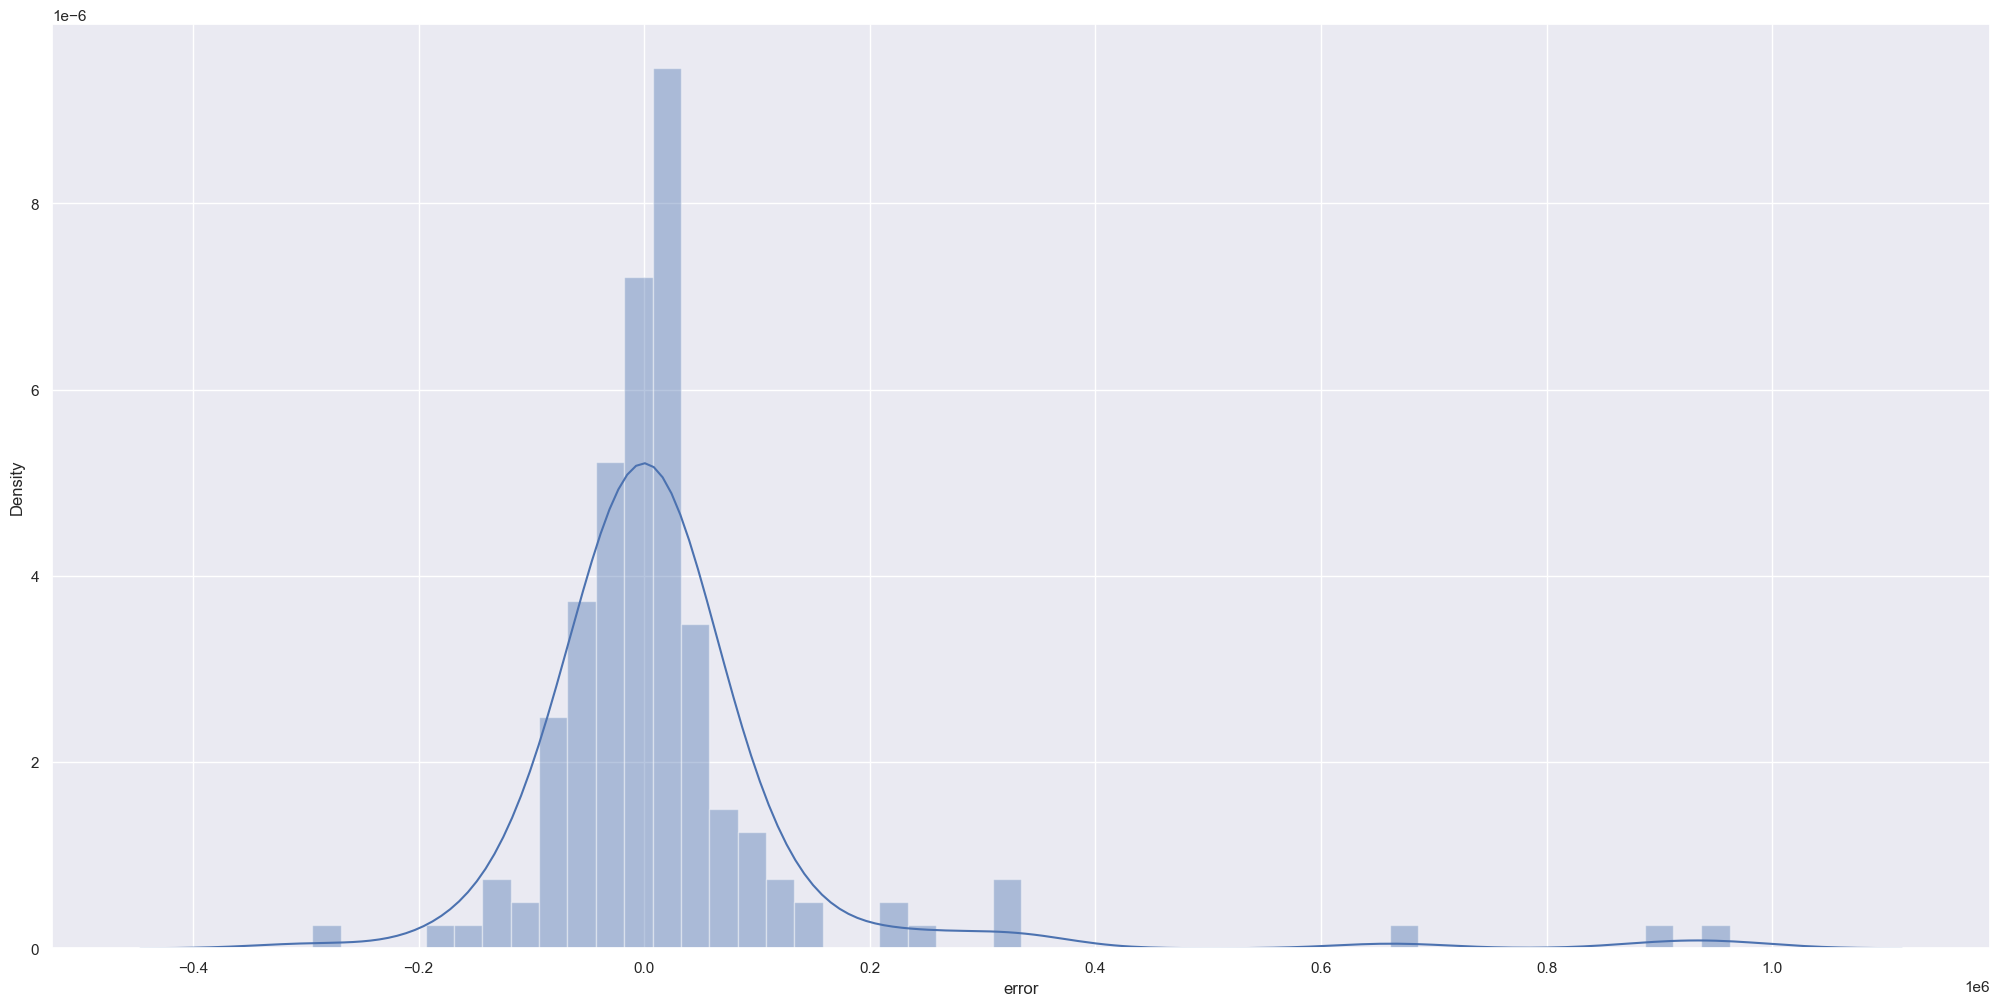

In [65]:
sns.distplot(df8_aux1['error']);

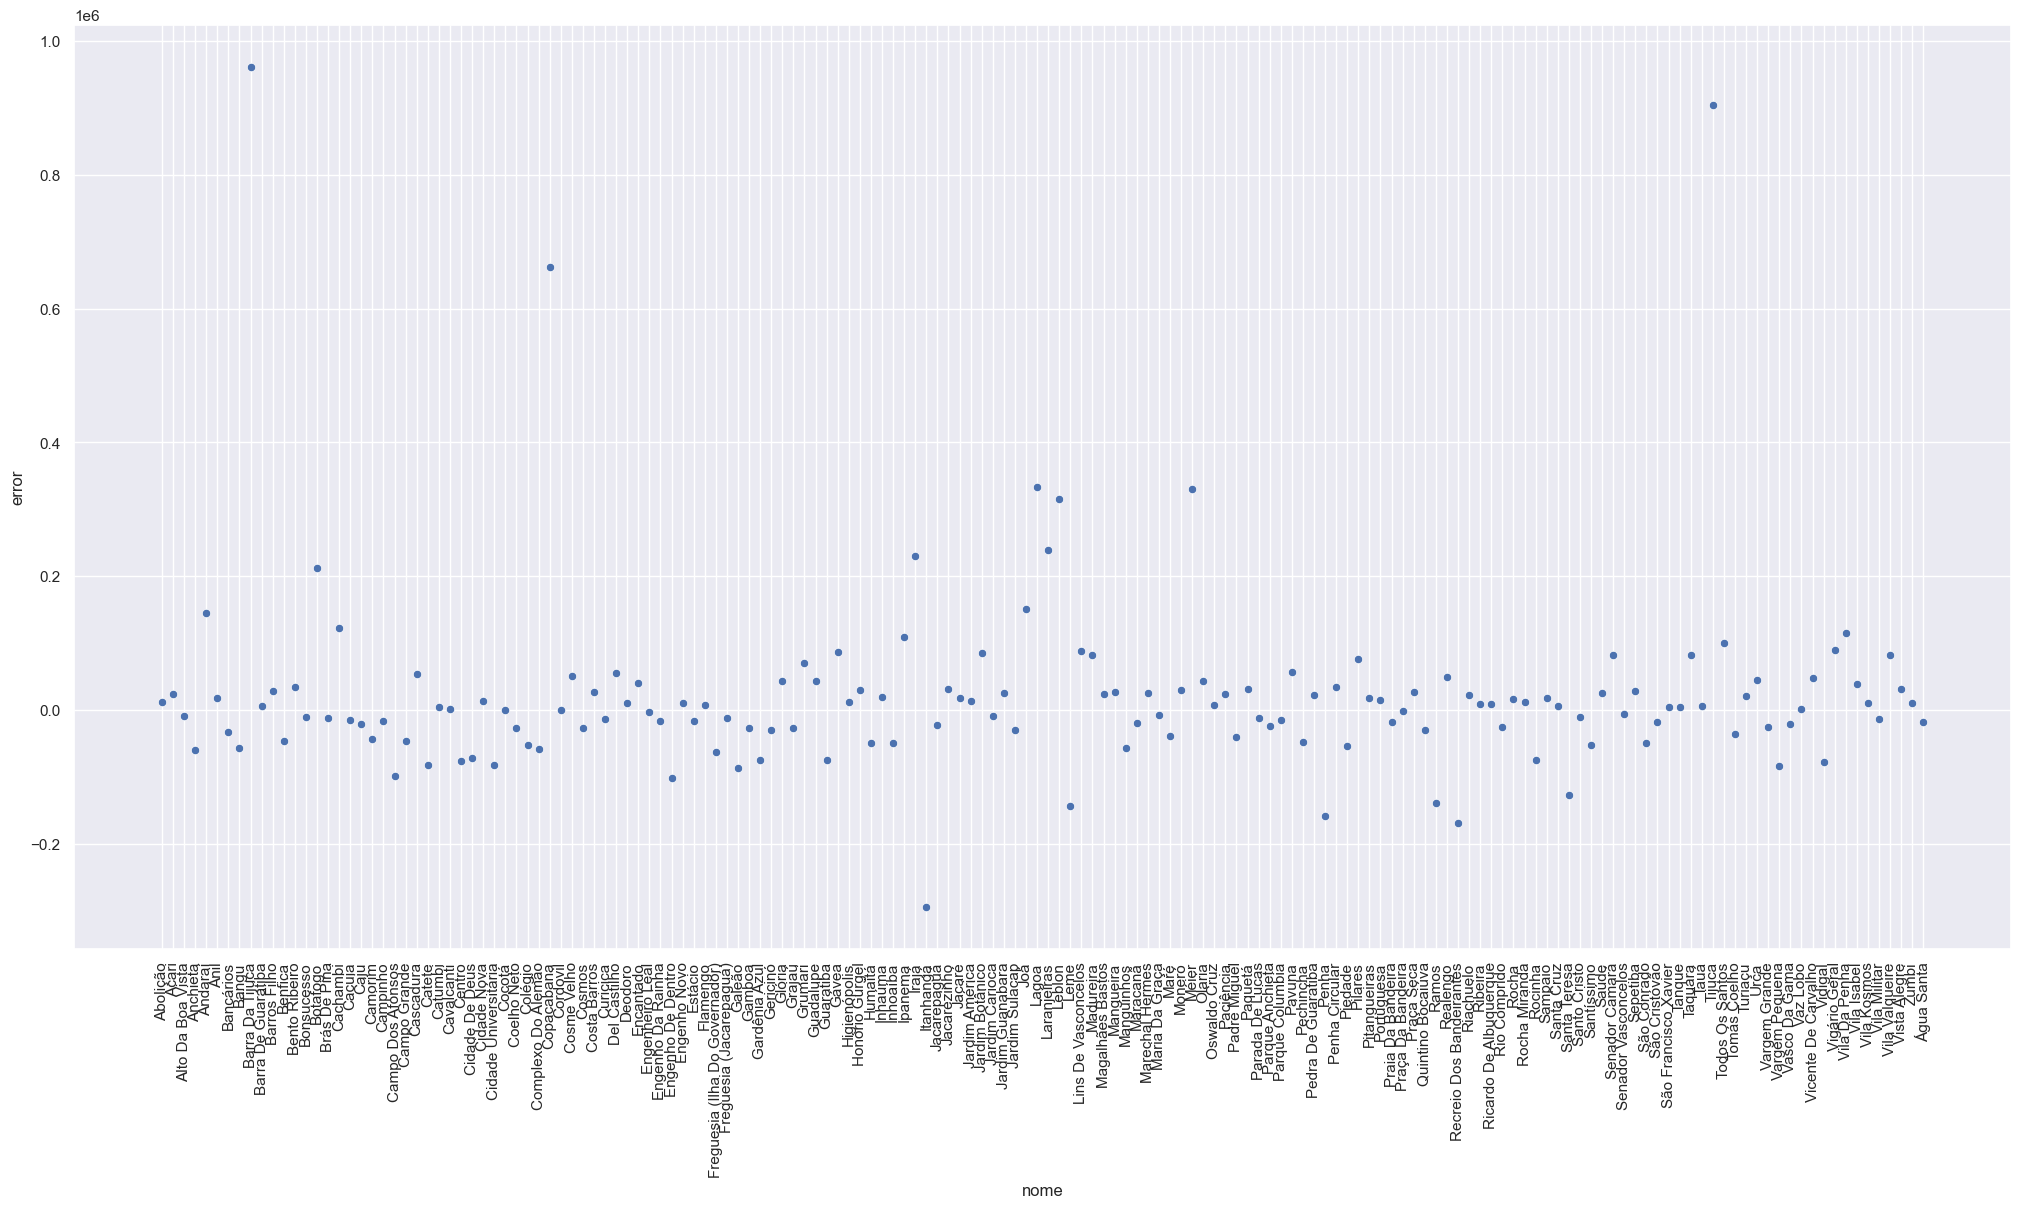

In [66]:
sns.scatterplot(x = 'nome', y = 'error', data = df8_aux1);
plt.xticks (rotation = 90);

### 8.2. Classificação

In [67]:
df8 = df2.copy()
df8_aux1['error_cl'] = df8['potencial'] - df8['potencial_classifier']

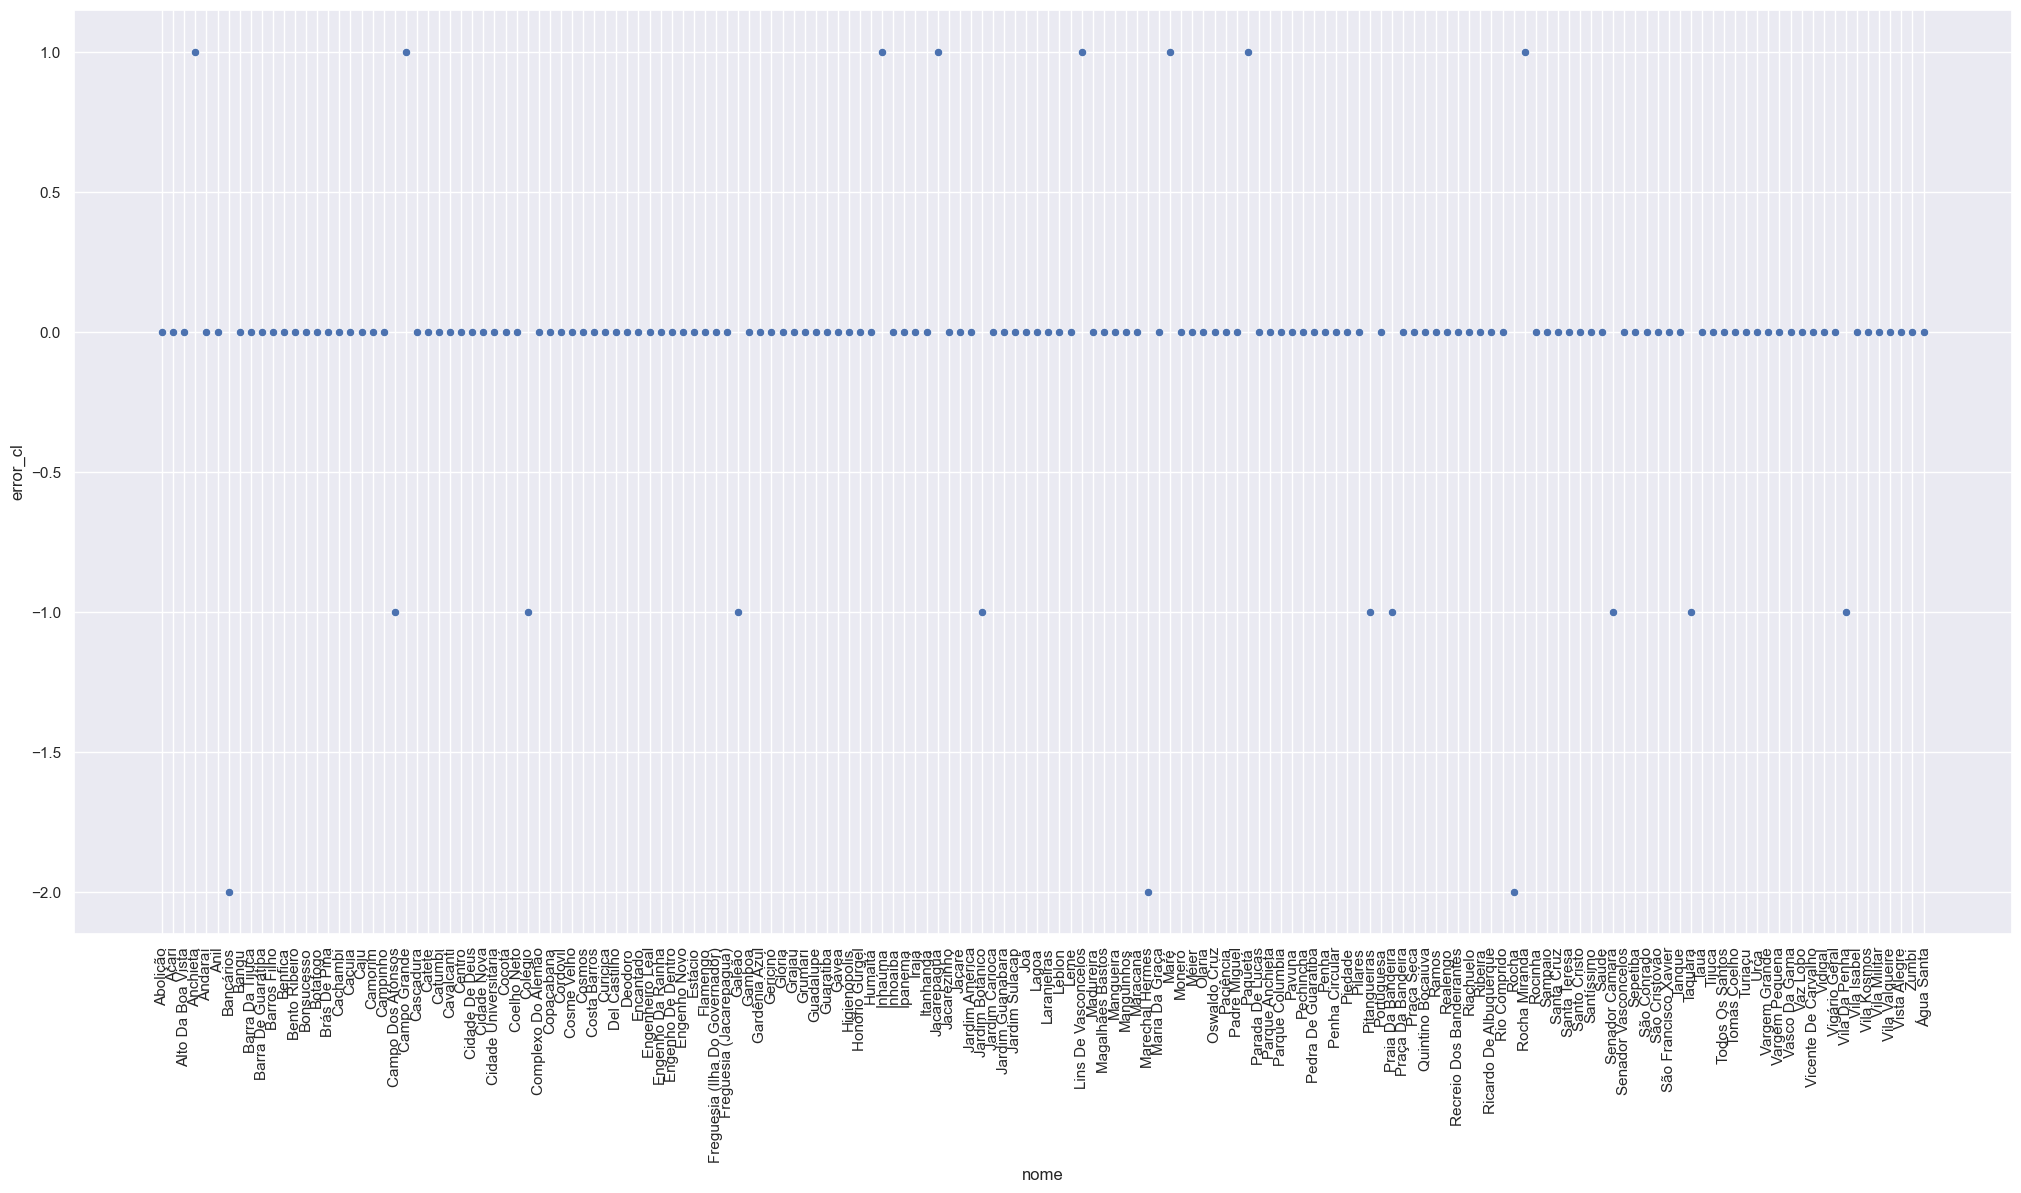

In [68]:
sns.scatterplot(x = 'nome', y = 'error_cl', data = df8_aux1);
plt.xticks (rotation = 90);

**1.** Pode-se observar os erros e acertos do modelo de classificação em classificar os
potenciais dos bairros. Há uma grande concentração de bairros com o erro em 0, mostrando
a efetividade do modelo usado. Em valores positivos, o modelo previu um potencial maior
do que o real. Em valores negativos, um potencial menor que o real.

## 9.0. PASSO 09 - MODELO NO DATASET DE SP

In [69]:
df9 = df_sp.copy()
df9 = df9[df9['população'] > 0]
df9['rendaMedia'] = df9['rendaMedia'].astype(float64)
df_sp = df9.copy()

### 9.1. Rescaling de Features

In [70]:
# popAte9
df9['popAte9'] = rs.transform (df9[['popAte9']].values)

# popDe10a14
df9['popDe10a14'] = rs.transform (df9[['popDe10a14']].values)

# popDe15a19
df9['popDe15a19'] = rs.transform (df9[['popDe15a19']].values)

# popDe20a24
df9['popDe20a24'] = rs.transform (df9[['popDe20a24']].values)

# popDe25a34
df9['popDe25a34'] = rs.transform (df9[['popDe25a34']].values)

# popDe35a49
df9['popDe35a49'] = rs.transform (df9[['popDe35a49']].values)

# popDe50a59
df9['popDe50a59'] = rs.transform (df9[['popDe50a59']].values)

# popMaisDe60
df9['popMaisDe60'] = rs.transform (df9[['popMaisDe60']].values)

# domiciliosA1
df9['domiciliosA1'] = mms.transform (df9[['domiciliosA1']].values)

# domiciliosA2
df9['domiciliosA2'] = rs.transform (df9[['domiciliosA2']].values)

# domiciliosB1
df9['domiciliosB1'] = rs.transform (df9[['domiciliosB1']].values)

# domiciliosB2
df9['domiciliosB2'] = rs.transform (df9[['domiciliosB2']].values)

# domiciliosC1
df9['domiciliosC1'] = rs.transform (df9[['domiciliosC1']].values)

# domiciliosC2
df9['domiciliosC2'] = rs.transform (df9[['domiciliosC2']].values)

# domiciliosD
df9['domiciliosD'] = rs.transform (df9[['domiciliosD']].values)

# domiciliosE
df9['domiciliosE'] = rs.transform (df9[['domiciliosE']].values)

# rendaMedia
df9['rendaMedia'] = rs.transform (df9[['rendaMedia']].values)

In [71]:
df9.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,7.30,3.34,5.37,3.77,8.56,13.33,5.89,5.83,0.00,-1.15,0.18,1.65,3.22,3.45,0.21,2.54,-0.30,NaN,NaN
161,35503020,Aclimação,São Paulo,SP,32791,0.24,-0.63,0.11,0.18,2.31,3.63,2.03,3.88,0.11,-0.14,1.20,0.28,0.01,-0.76,-1.12,-0.22,2.71,NaN,NaN
162,355030285,Adventista,São Paulo,SP,104193,8.93,3.67,5.91,4.57,10.75,14.57,6.55,5.35,0.00,-1.32,-0.35,2.00,4.53,5.54,0.80,2.61,-0.45,NaN,NaN
163,35503088,Água Branca,São Paulo,SP,12721,-0.67,-1.08,-0.89,-0.76,0.14,0.61,-0.10,0.87,0.05,-0.86,-0.26,-0.62,-0.70,-1.07,-1.26,-1.04,2.95,NaN,NaN
164,35503066,Água Funda,São Paulo,SP,48417,2.13,0.31,1.41,1.11,3.71,5.99,3.20,4.51,0.00,-1.11,-0.10,0.71,1.73,0.61,-0.57,0.42,-0.02,NaN,NaN


### 9.2. Faturamento

In [72]:
df9_cols_selected = df9[['popAte9', 'popDe10a14',	'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2', 'domiciliosB1',
                        'domiciliosB2', 'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE', 'rendaMedia']]

In [73]:
yhat_sp = model_xgb_tuned.predict(df9_cols_selected)

In [74]:
df_sp['predictions'] = np.expm1(yhat_sp)

### 9.3. Potencial

In [75]:
yhat_rfc_sp = model_rfc_tuned.predict(df9_cols_selected)

In [76]:
df_sp['potencial_classifier'] = yhat_rfc_sp
df_sp['potencial_classifier'] = df_sp['potencial_classifier'].apply(lambda x: 'Baixo' if x == 0 else 'Médio' if x == 1 else 'Alto')

### 9.4. Clusterização

In [77]:
df9_etaria = df9[['popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60']]
df9_classe = df9[['domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE']]

cols_etaria = [['popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60']]
cols_classe = [['domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE']]

#### 9.4.1. Estudo do Espaço

##### 9.4.1.1. PCA

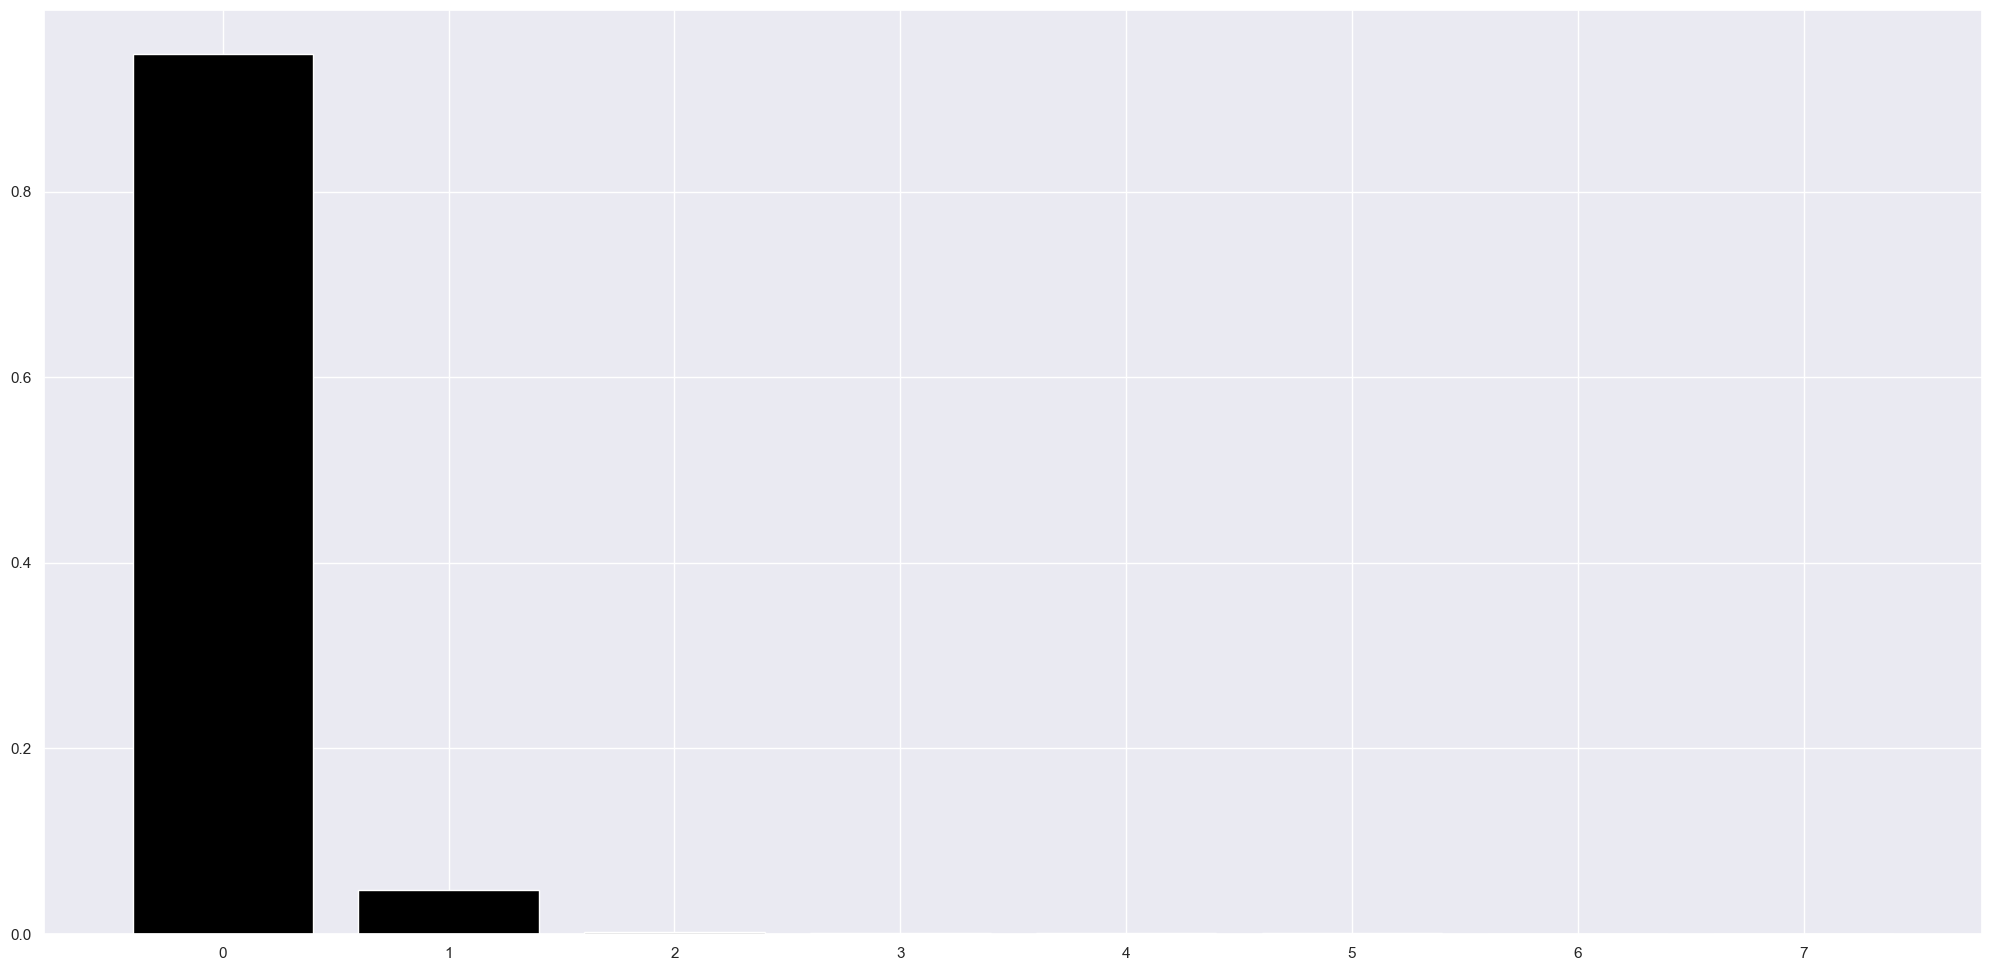

In [78]:
pca = PCA(n_components=df9_etaria.shape[1])

principal_components = pca.fit_transform(df9_etaria)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot: xlabel='0', ylabel='1'>

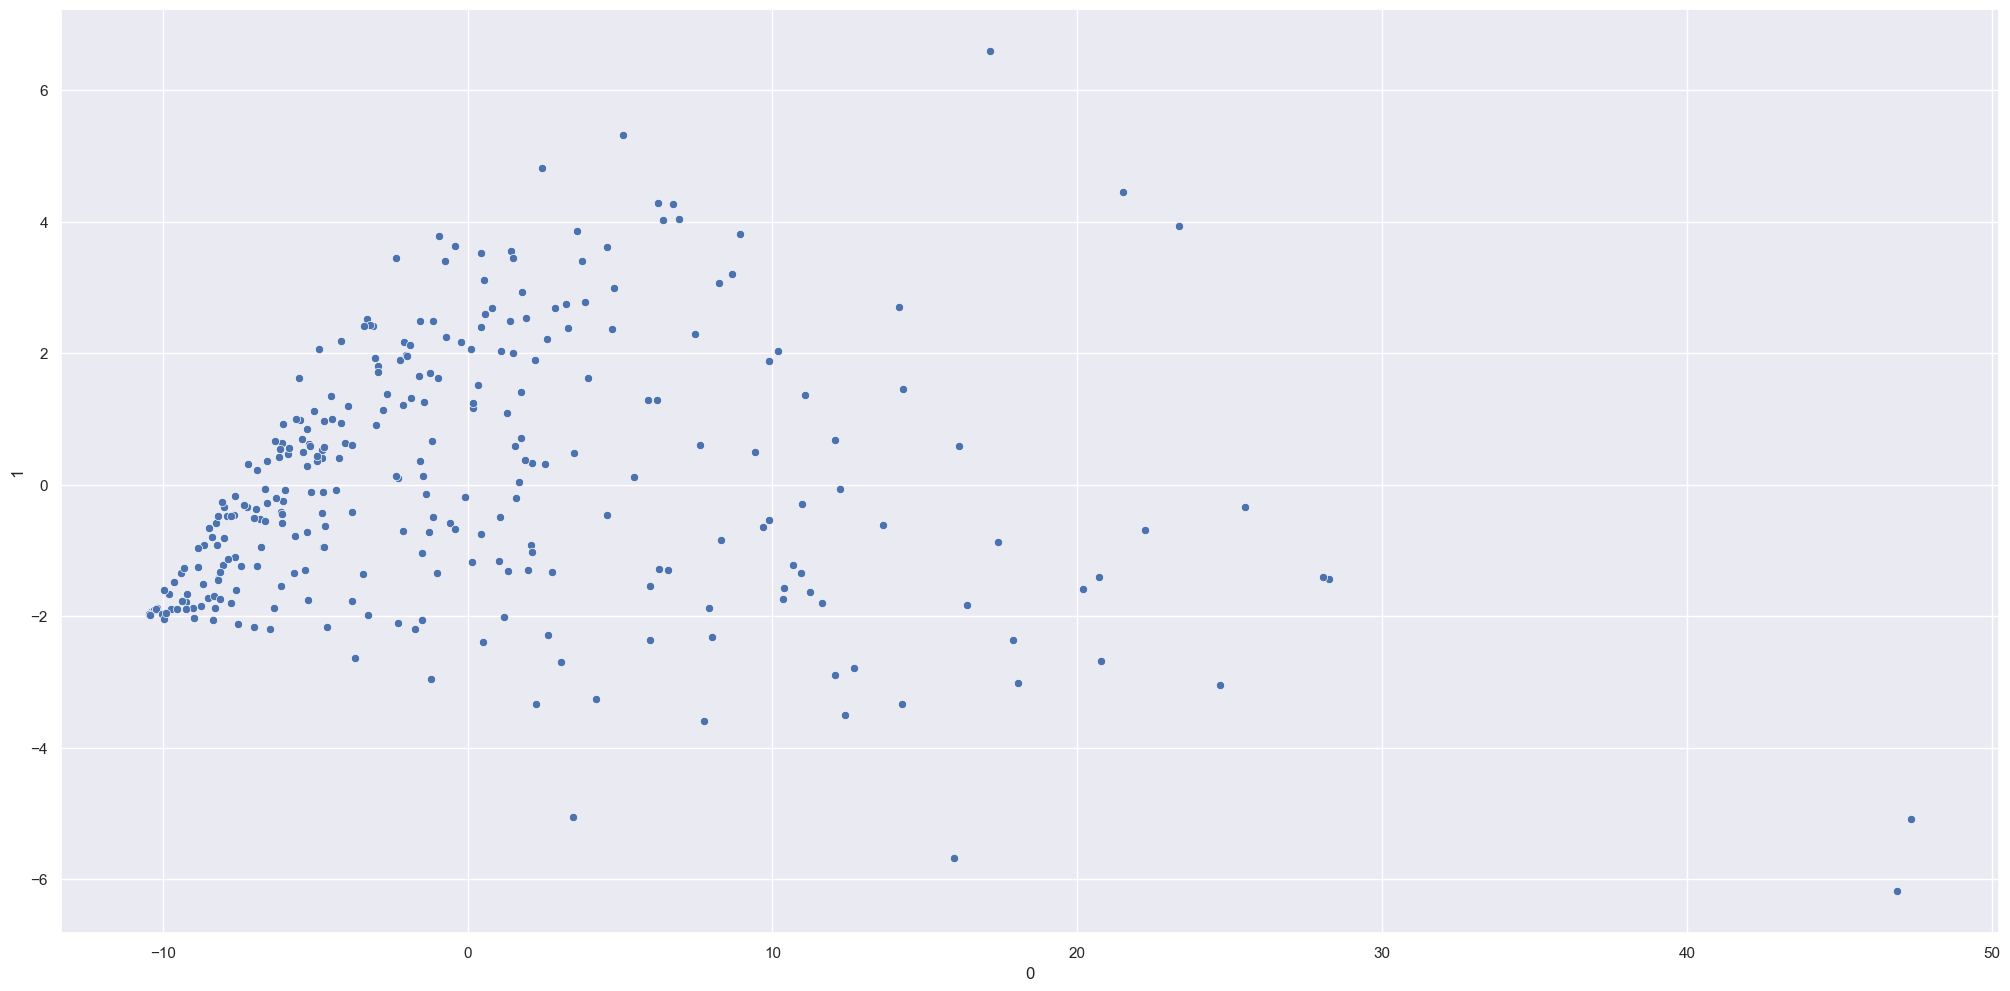

In [79]:
sns.scatterplot( x=0, y=1, data=df_pca )

##### 9.4.1.2. Tree-Based Embedding - Faixa Etária

In [80]:
df9_etaria = df_sp[['popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60']]

In [81]:
df91 = df9_etaria.copy()
df91['popDe25a50'] = df91['popDe25a34'] + df91['popDe35a49']

df91 = df91.drop(['popDe25a34', 'popDe35a49'], axis = 1)
df9_etaria = df91.copy()

In [82]:
# popAte9
df91['popAte9'] = rs.transform (df91[['popAte9']].values)

# popDe10a14
df91['popDe10a14'] = rs.transform (df91[['popDe10a14']].values)

# popDe15a19
df91['popDe15a19'] = rs.transform (df91[['popDe15a19']].values)

# popDe20a24
df91['popDe20a24'] = rs.transform (df91[['popDe20a24']].values)

# popDe50a59
df91['popDe50a59'] = rs.transform (df91[['popDe50a59']].values)

# popMaisDe60
df91['popMaisDe60'] = rs.transform (df91[['popMaisDe60']].values)

# popDe25a50
df91['popDe25a50'] = rs.fit_transform (df91[['popDe25a50']].values)
pickle.dump(rs, open('parameter/popDe25a50_scaler.pkl', 'wb'))

In [83]:
X_etaria = df91.drop('popDe25a50', axis = 1)
y_etaria = df91['popDe25a50']

# model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit
rf_model.fit(X_etaria, y_etaria)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X_etaria))

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

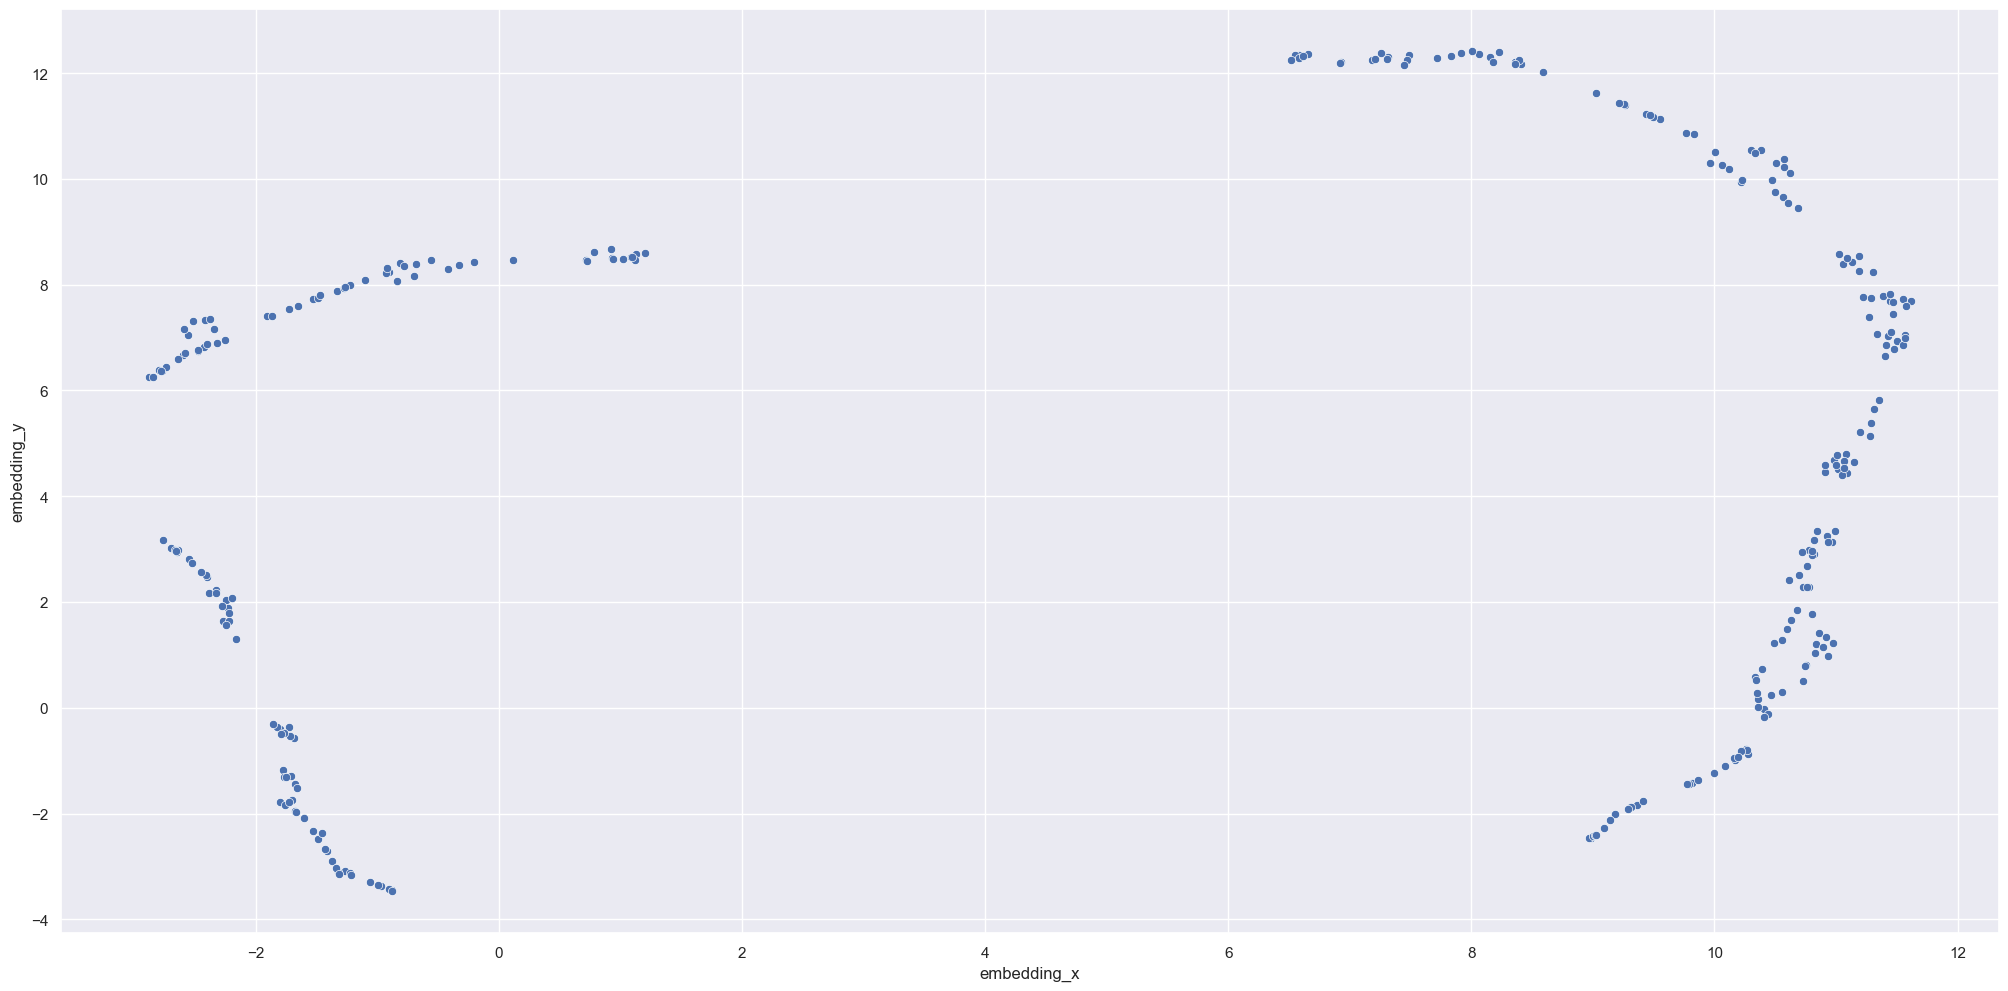

In [84]:
# Reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_tree)

**1.** Boa separação entre clusters. Para esse projeto, foi considerado 3 clusters, por questão de negócio apenas.

##### 9.4.1.3. UMAP - Classe Social

In [85]:
df9_classe = df_sp[['domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE']]

In [86]:
df92 = df9_classe.copy()
df92['A'] = df92['domiciliosA1'] + df92['domiciliosA2']
df92['B'] = df92['domiciliosB1'] + df92['domiciliosB2']
df92['C'] = df92['domiciliosC1'] + df92['domiciliosC2']

df92 = df92.drop(['domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2'], axis = 1)

df9_classe = df92.copy()

In [87]:
# domiciliosA1
df92['A'] = rs.fit_transform (df92[['A']].values)
pickle.dump(rs, open('parameter/A_scaler.pkl', 'wb'))

# domiciliosA2
df92['B'] = rs.fit_transform (df92[['B']].values)
pickle.dump(rs, open('parameter/B_scaler.pkl', 'wb'))

# domiciliosB1
df92['C'] = rs.fit_transform (df92[['C']].values)
pickle.dump(rs, open('parameter/C_scaler.pkl', 'wb'))

# domiciliosD
df92['domiciliosD'] = rs.transform (df92[['domiciliosD']].values)

# domiciliosE
df92['domiciliosE'] = rs.transform (df92[['domiciliosE']].values)

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

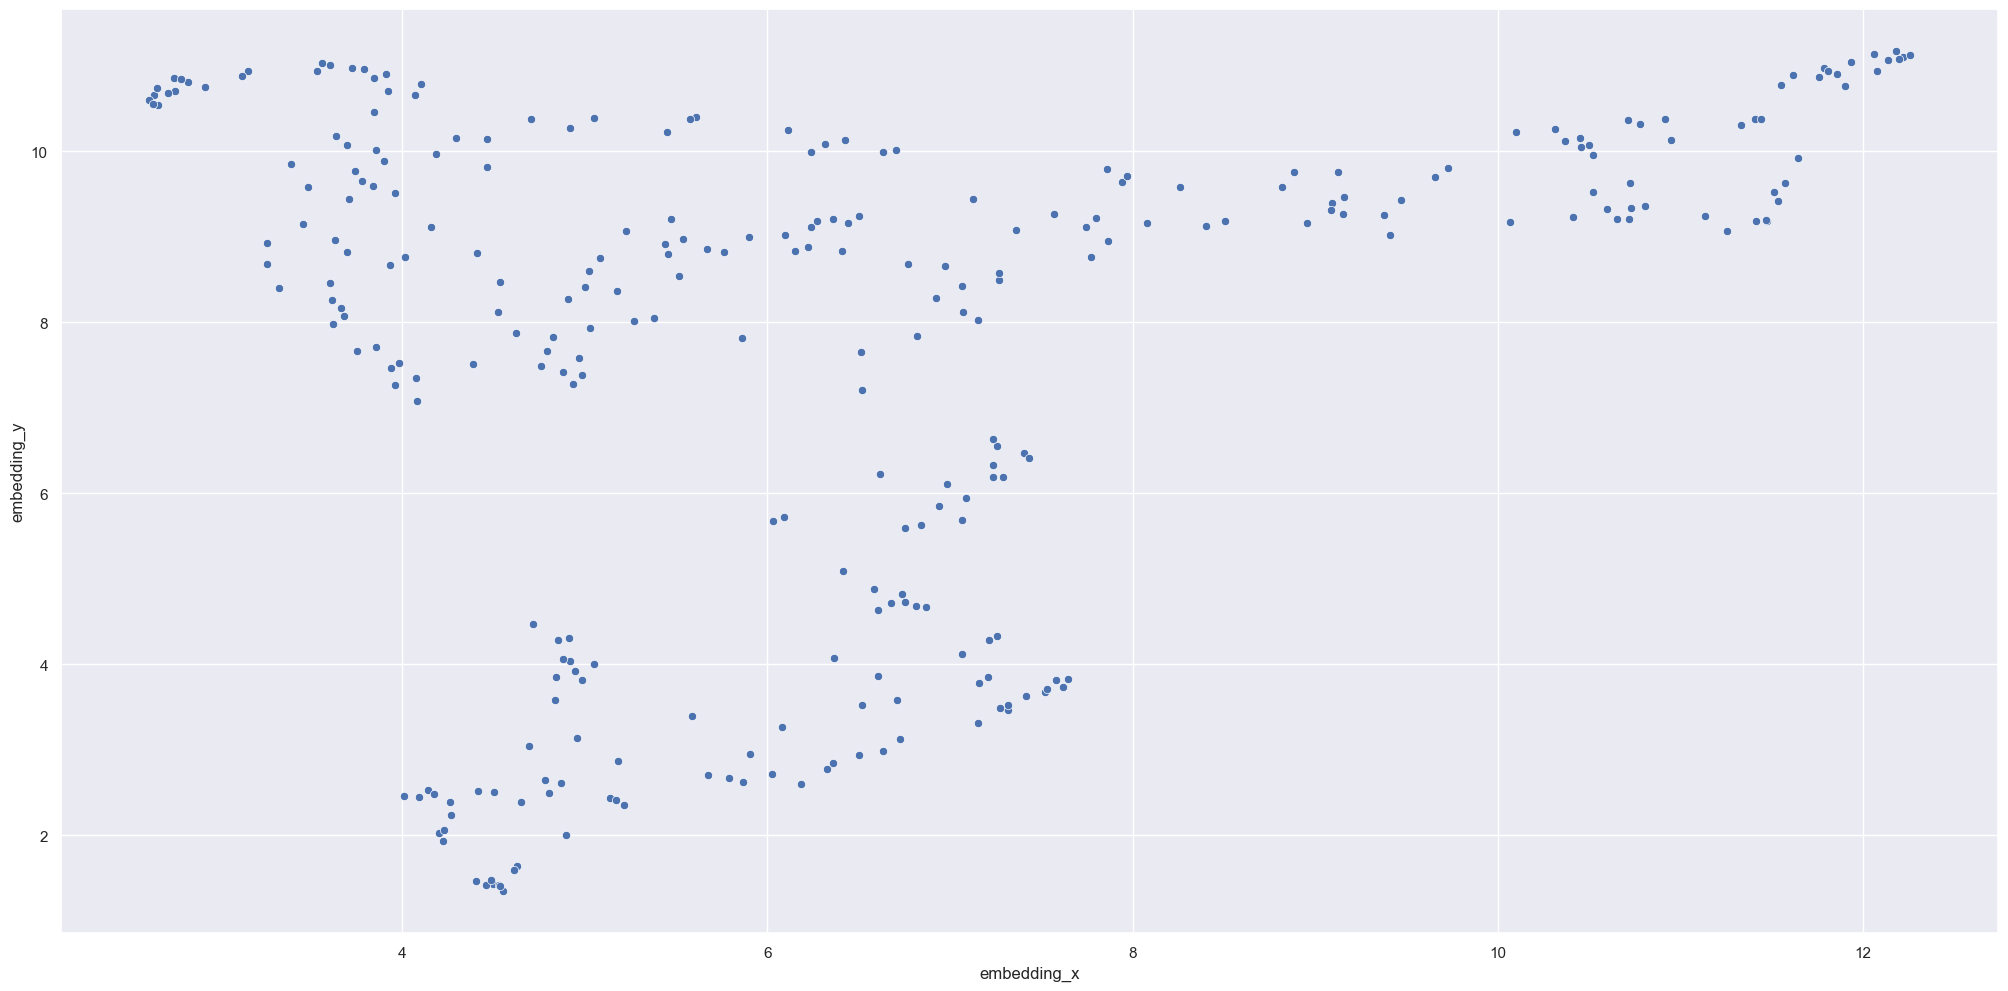

In [88]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df92)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap)

**1.** Não há uma boa distinção entre clusters. Muitos estarão sobrepostos.

#### 9.4.2. Model Training

##### 9.4.2.1. Faixa Etária

In [89]:
X_etaria = df_tree.copy()

In [90]:
 # model definition
k = 3

## model definition
gmm_model_et = GaussianMixture(n_components=k, n_init=300, random_state=32)

# model training
gmm_model_et.fit(X_etaria)


# model predict
labels = gmm_model_et.predict(X_etaria)

##### 9.4.2.2. Classe Social

In [91]:
 # model definition
k = 5

## model definition
gmm_model_cl = GaussianMixture(n_components=k, n_init=300, random_state=32)

# model training
gmm_model_cl.fit(df92)

# model predict
labels_classe = gmm_model_cl.predict(df92)

#### 9.4.3. Análise de Clusters

In [92]:
# Faixa Etária
df9_etaria['cluster'] = labels
X_etaria['cluster'] = labels

# Classe Social
df_umap['cluster_classe'] = labels_classe
df9_classe['cluster_classe'] = labels_classe

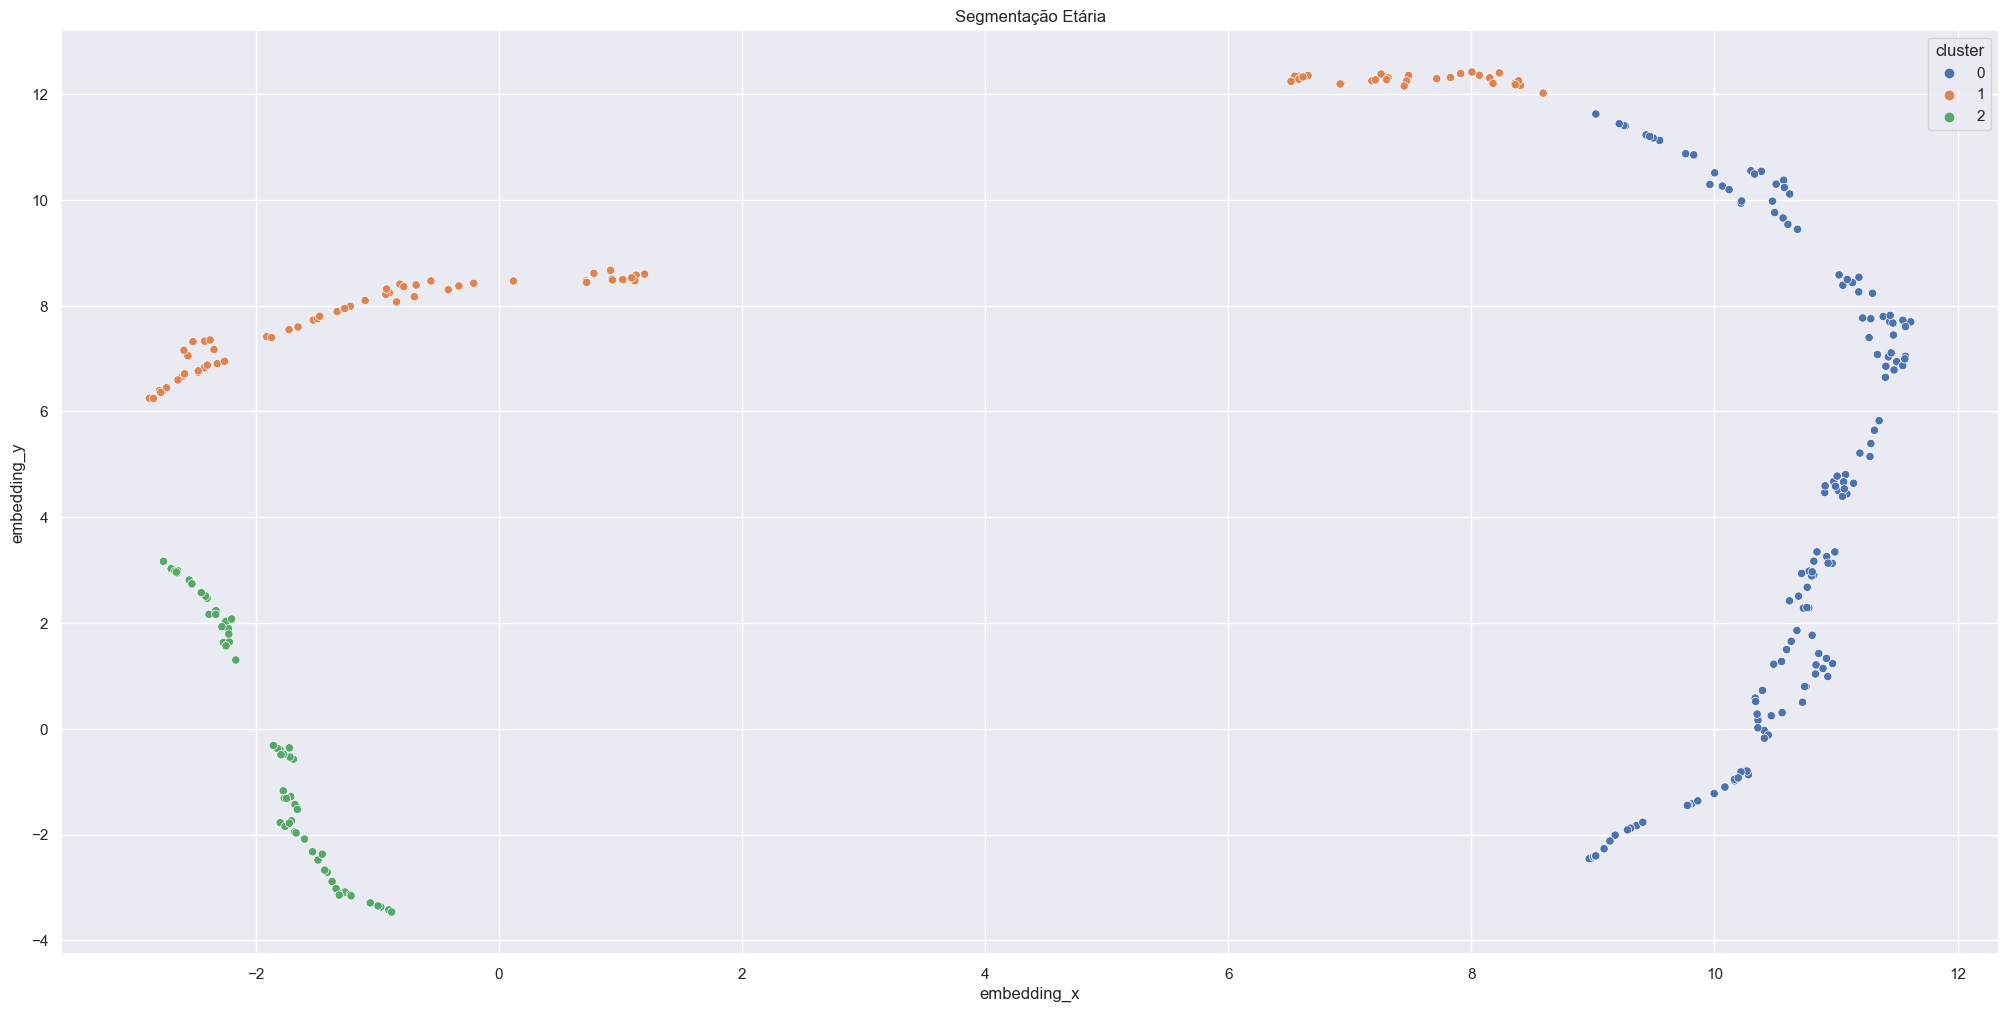

In [93]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=X_etaria, palette='deep');
plt.title('Segmentação Etária');

**1.** Bom resultado. Um número de clusters igual a 4 talvez apresentaria uma distinção ainda melhor.

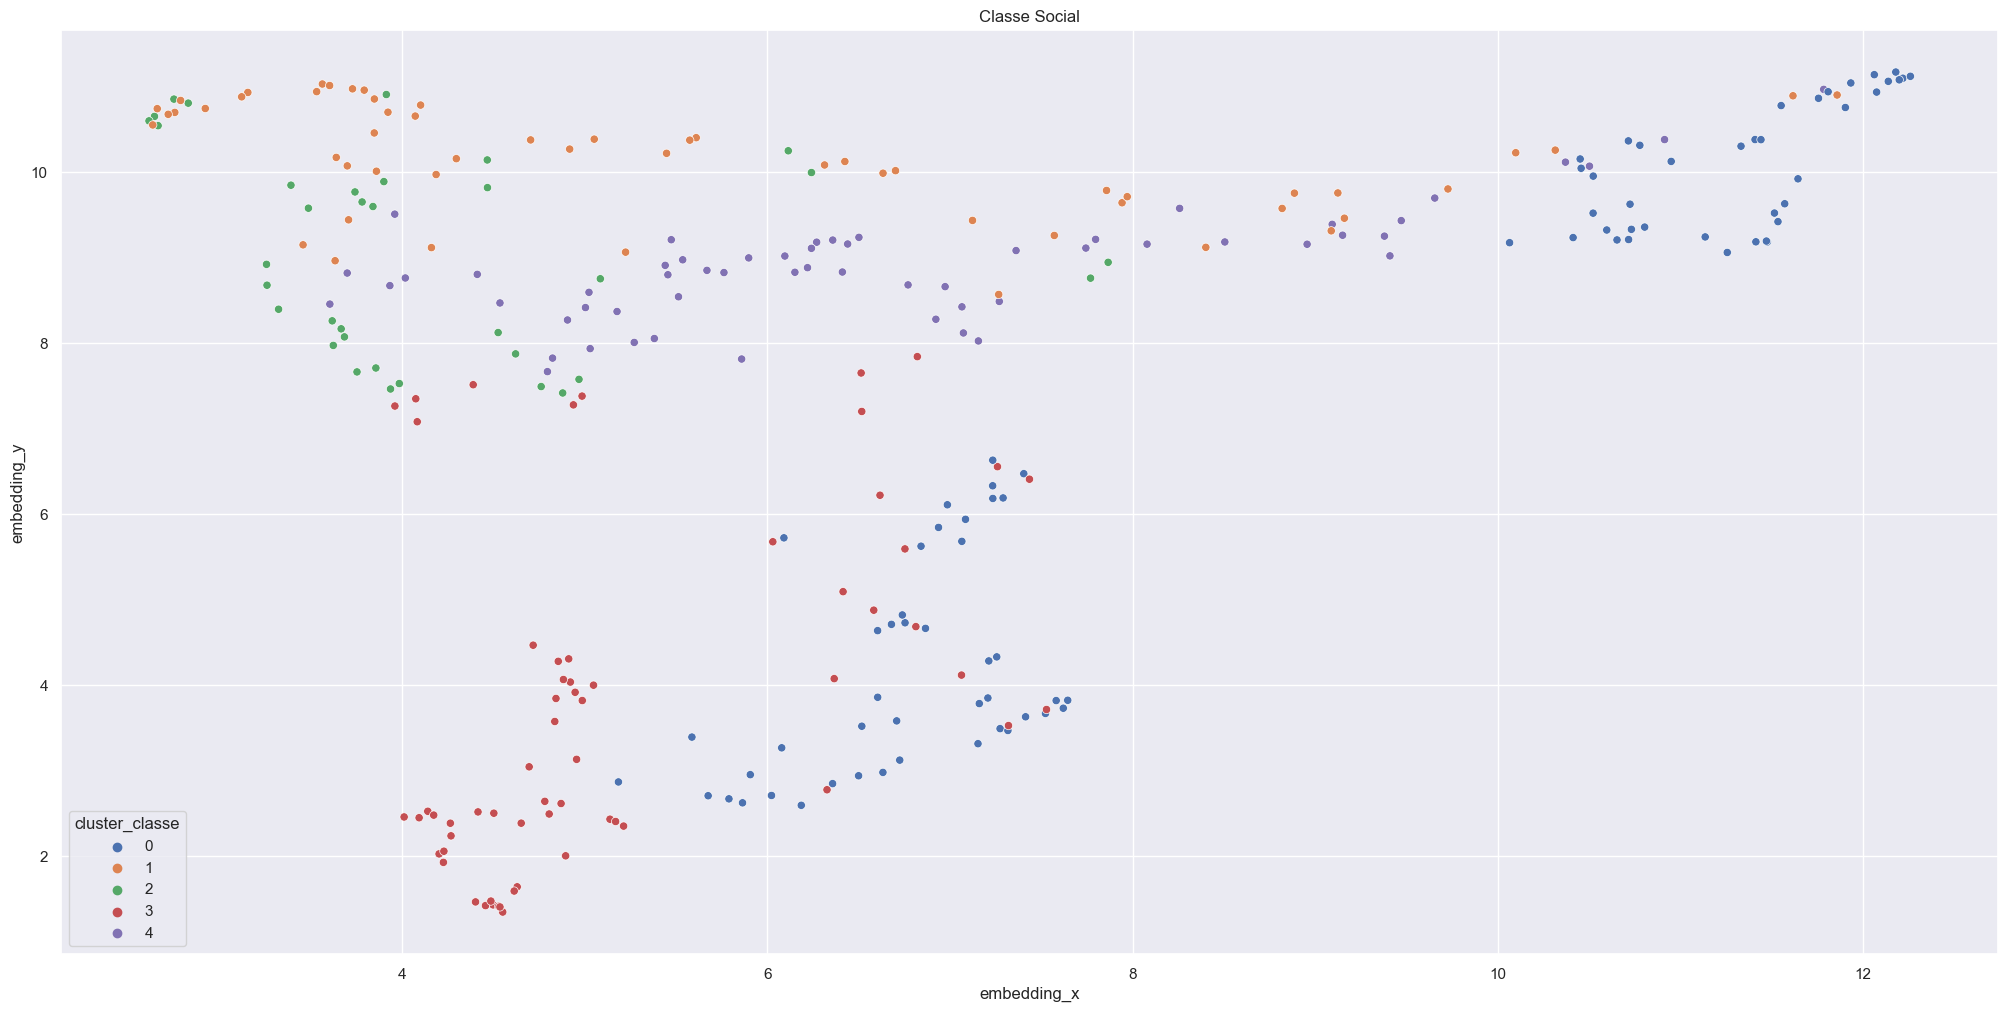

In [94]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster_classe', data=df_umap, palette='deep');
plt.title('Classe Social');

**1.** Separação dos clusters não foi muito boa. Para um retrabalho do modelo, cogitar um estudo de feature engineering para relacionar melhor as classes sociais.

#### 9.4.4. Perfis dos Clusters

In [95]:
# Avg popAte9
df_cluster = df9_etaria[['popAte9', 'cluster']].groupby('cluster').mean().reset_index()

# Avg popDe10a14
df_avg_popDe10a14 = df9_etaria[['popDe10a14', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popDe10a14, how='inner', on='cluster')

# Avg popDe15a19
df_avg_popDe15a19 = df9_etaria[['popDe15a19', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popDe15a19, how='inner', on='cluster')

# Avg popDe20a24
df_avg_popDe20a24 = df9_etaria[['popDe20a24', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popDe20a24, how='inner', on='cluster')

# Avg popDe50a59
df_avg_popDe50a59 = df9_etaria[['popDe50a59', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popDe50a59, how='inner', on='cluster')

# Avg popMaisDe60
df_avg_popMaisDe60 = df9_etaria[['popMaisDe60', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popMaisDe60, how='inner', on='cluster')

# Avg popDe25a50
df_avg_popDe25a50 = df9_etaria[['popDe25a50', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_popDe25a50, how='inner', on='cluster')

df_cluster.sort_values('popDe25a50', ascending=False)

,cluster,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe50a59,popMaisDe60,popDe25a50
2,2,12940.03,6471.11,9507.61,7488.13,10708.53,10776.85,36229.66
1,1,4824.93,2349.07,3632.69,3181.98,5892.17,7587.48,16999.51
0,0,1418.73,641.29,1063.33,1047.30,2248.73,3481.23,6076.52


**1.** Cluster 0 (Faixa Etária Alvo) = Adulto\
**2.** Cluster 1 = Idoso\
**3.** Cluster 2 = Jovem

In [96]:
# Avg domicilios A
df_cluster_classe = df9_classe[['A', 'cluster_classe']].groupby('cluster_classe').mean().reset_index()

# Avg domicilios B
df_avg_B = df9_classe[['B', 'cluster_classe']].groupby('cluster_classe').mean().reset_index()
df_cluster_classe = pd.merge(df_cluster_classe, df_avg_B, how='inner', on='cluster_classe')

# Avg domicilios C
df_avg_C = df9_classe[['C', 'cluster_classe']].groupby('cluster_classe').mean().reset_index()
df_cluster_classe = pd.merge(df_cluster_classe, df_avg_C, how='inner', on='cluster_classe')

# Avg domicilios D
df_avg_domiciliosD = df9_classe[['domiciliosD', 'cluster_classe']].groupby('cluster_classe').mean().reset_index()
df_cluster_classe = pd.merge(df_cluster_classe, df_avg_domiciliosD, how='inner', on='cluster_classe')

# Avg domicilios E
df_avg_domiciliosE = df9_classe[['domiciliosE', 'cluster_classe']].groupby('cluster_classe').mean().reset_index()
df_cluster_classe = pd.merge(df_cluster_classe, df_avg_domiciliosE, how='inner', on='cluster_classe')

df_cluster_classe

,cluster_classe,A,B,C,domiciliosD,domiciliosE
0,0,999.29,1900.43,999.71,72.80,437.96
1,1,0.02,3901.87,11536.18,1863.15,4739.20
2,2,632.00,7450.71,11645.83,1682.23,4945.26
3,3,2784.21,5628.23,3022.32,278.29,1706.60
4,4,217.60,4305.79,6023.84,666.67,2275.91


**1.** Cluster 0 (Classe Alvo) = Classe A\
**2.** Cluster 1 = Classe E\
**3.** Cluster 2 (Classe Alvo) = Classe C\
**4.** Cluster 3 = Classe B\
**5.** Cluster 4 = Classe D

In [97]:
df_sp['etaria'] = labels
df_sp['etaria'] = df_sp['etaria'].apply(lambda x: 'Adulto' if x == 0 else 'Idoso' if x == 1 else 'Jovem')

df_sp['classe'] = labels_classe
df_sp['classe']= df_sp['classe'].apply(lambda x: 'A' if x == 0 else 'B' if x == 3 else 'C' if x == 2 else 'D' if x == 4 else 'E')

In [98]:
df_sp.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,predictions,potencial_classifier,etaria,classe
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.00,NaN,NaN,96022.31,Médio,Jovem,C
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.00,NaN,NaN,1520011.50,Alto,Idoso,B
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.00,NaN,NaN,79683.20,Médio,Jovem,E
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.00,NaN,NaN,1183156.12,Médio,Adulto,A
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.00,NaN,NaN,701110.06,Médio,Idoso,D
